In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch_directml
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchvision import transforms
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from piqa import MS_SSIM

In [2]:
# use CUDA processors if available
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch_directml.device()
print(f"Using {device} device")

Using cpu device


In [3]:
def get_img_path(digit, i):
    # get the image path given the digit and the index of the image within the digit
    # eg. get_img_path(4, 12) denotes the 13th image of digit 4
    if digit == 0:
        img_num = 9000
    else:
        img_num = (digit - 1) * 1000
    img_num += (i+1)
    return f'../data/labels/{digit}/image{img_num}.png'


def gather_data(exp_type: str, detect_type: str, feature_name: str, num_features: int):
    # prepare feature data and image paths
    features = None
    image_paths = []
    digits = []
    for digit in range(10):
        fpath = f'../data/features/{exp_type}/{detect_type}/{feature_name}/{feature_name}{digit}.csv'
        data = pd.read_csv(fpath, header=None)

        for i in range(len(data)):
            dig = data[0][i]
            image_paths.append(get_img_path(dig, i))
            digits += [dig]

        data = data.drop(0, axis=1)
        data = data.iloc[:,:num_features]
        if features is None:
            features = data.to_numpy()
        else:
            features = np.append(features, data.to_numpy(), axis=0)

    features = torch.tensor(features.astype(np.float32)).to(device)
    return features, image_paths, digits

# define data transformations
def feature_transform(x: torch.Tensor):
    # standardizes the features of a given data point
    mean = x.mean()
    std = x.std()
    return x.sub(mean).div(std).to(device)


def img_transform(y: str):
    # transforms an image path to a usable tensor
    image = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    convert_tensor = A.Compose([A.ToFloat(max_value=255), ToTensorV2()])
    try:
        thingy = convert_tensor(image=image)['image']
        return thingy.to(device)
    except Exception as e:
        print(e)
        raise Exception(f"cannot load image: {y}")


def digit_transform(y: int):
    return y


# create Datasets and DataLoaders
class ReconstructionData(Dataset):
    def __init__(self, raw_features: torch.Tensor, labels: list, feature_transform, label_transform: None):
        self.features = raw_features
        self.labels = labels
        self.feature_transform = feature_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        data = self.feature_transform(self.features[idx])
        label = self.label_transform(self.labels[idx])
        return data, label


def prep_data(features, labels, val_size, feature_transform, label_transform, batch_size):
    # create train and validation dataloaders
    train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=val_size)
    train_data = ReconstructionData(train_features, train_labels, feature_transform, label_transform)
    val_data = ReconstructionData(val_features, val_labels, feature_transform, label_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader


class ImgReconstructNN(nn.Module):
    def __init__(self, num_features: int):
        super(ImgReconstructNN, self).__init__()
        self.reconstruct_stack = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.PReLU(),
            nn.Linear(1024, 4096),
            nn.PReLU(),
            nn.Linear(4096, (4*28)*(4*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 4*28, 4*28)),
            nn.Conv2d(1,4,4,padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(4,1,2,padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.reconstruct_stack(x)
        return torch.nan_to_num(logits)


class ImgReconstructClassifyNN(nn.Module):
    def __init__(self):
        super(ImgReconstructClassifyNN, self).__init__()
        self.reconstruct_classify_stack = nn.Sequential(
            nn.Linear(300, 2048),
            nn.PReLU(),
            nn.Linear(2048, 2048),
            nn.PReLU(),
            nn.Linear(2048, (8*28)*(8*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 8*28, 8*28)),
            nn.Conv2d(1, 1, 8, padding=4),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 4, padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 2, padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Conv2d(10, 20, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Linear(320, 50),
            nn.PReLU(),
            nn.Linear(50, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.reconstruct_classify_stack(x)
        return logits


# Training loop
def train_loop(dataloader: DataLoader, val_dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, print_loss: bool, train_losses: list, val_losses: list) -> list:
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    train_losses.append(train_loss)
    if print_loss:
        print(f"Avg batch loss: {train_loss:>8f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for (X, y) in val_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        train_loss /= num_batches
        val_losses.append(test_loss)
    model.train()

    return train_losses, val_losses


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def train_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []
    for t in range(epochs):
        print_loss = False
        if (t % 8 == 7) or (t==0):
            print_loss = True
            print("-------------------------------")
            print(f"Epoch {t+1}")
        train_losses, val_losses = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, print_loss, train_losses, val_losses)
    print("Done!")
    return train_losses, val_losses


def plot_loss(losses: list, val: bool) -> None:
    losses = np.array(torch.tensor(losses).cpu())
    plt.plot(losses, color='red')
    plt.ylabel('Average Batch Loss') #set the label for y axis
    plt.xlabel('Epoch') #set the label for x-axis
    if val:
        plt.title("Validation Loss over Epochs") #set the title of the graph
    else:
        plt.title("Training Loss over Epochs") #set the title of the graph
    plt.show() #display the graph


l1 = nn.L1Loss()
class L1_SSIM_loss(MS_SSIM):
    def forward(self, x, y):
        return (0.5 * (1. - super().forward(x, y))) + (0.5 * l1.forward(x, y))


def reconstruct(exp_type, detect_type, feature_name, batch_size, val_size, epochs, loss_fn, learning_rate, num_features):
    print(f"\nTRAINING RECONSRTUCTION MODEL FOR: {feature_name}\n")
    print("PART 1")
    features, image_paths, digits = gather_data(exp_type, detect_type, feature_name, num_features)
    print("PART 2")
    train_dataloader, val_dataloader = prep_data(features, image_paths, val_size, feature_transform, img_transform, batch_size)
    print("PART 3")
    model = ImgReconstructNN(num_features).to(device)
    print(model)
    print("PART 4")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    print("PART 5")
    train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 6")
    plot_loss(train_losses, False)
    plot_loss(val_losses, True)
    print("PART 7")
    model, val_loss, val_psnr, val_ssim = reconstruct_test_loop(val_dataloader, model, loss_fn)
    saved_losses_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/reconstruct_losses.pt'
#     torch.save((train_losses, val_loss), saved_losses_loc)
    return val_loss, val_psnr, val_ssim



TRAINING RECONSRTUCTION MODEL FOR: sNdn40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.486358
-------------------------------
Epoch 8
Avg batch loss: 0.189101
-------------------------------
Epoch 16
Avg batch 

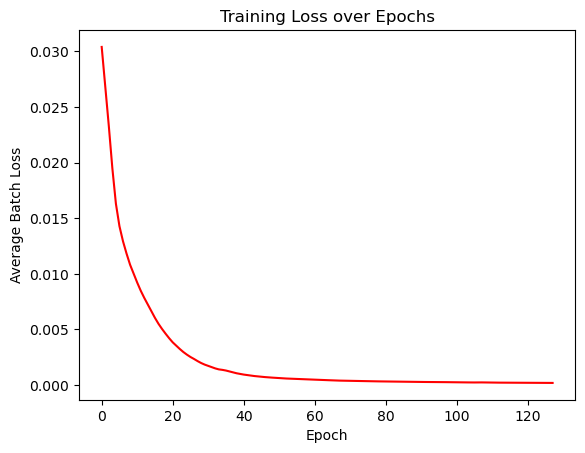

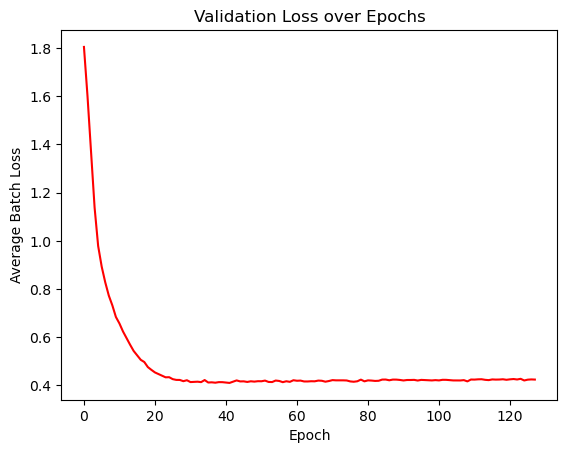

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.105886
Avg batch PSNR: 15.837703
Avg batch SSIM: 0.598376

TRAINING RECONSRTUCTION MODEL FOR: s0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.477507
-------------------------------
Epoc

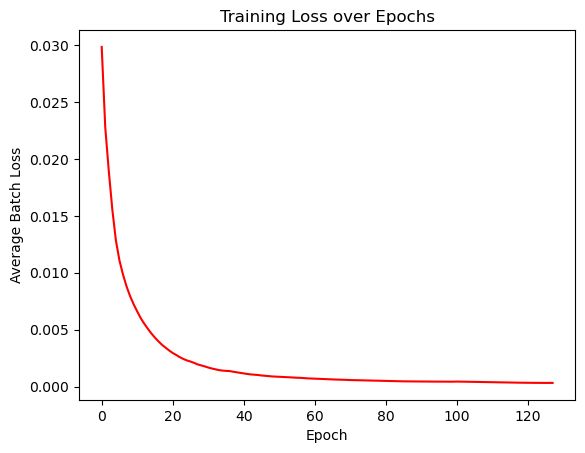

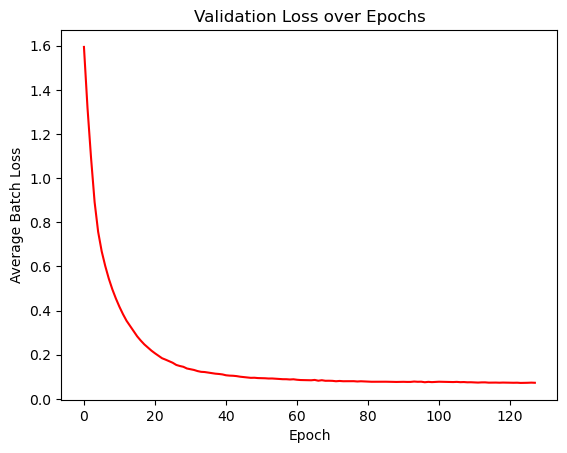

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018261
Avg batch PSNR: 24.064550
Avg batch SSIM: 0.941619

TRAINING RECONSRTUCTION MODEL FOR: s100tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.520761
-------------------------------
Epoc

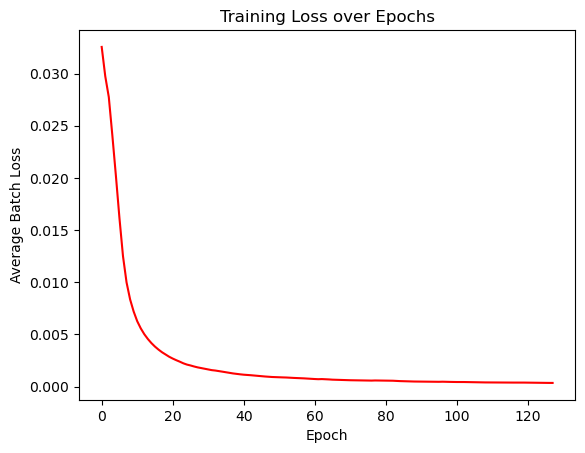

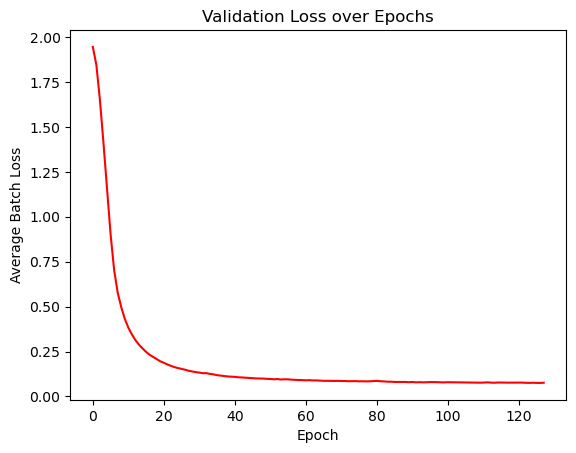

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.019106
Avg batch PSNR: 23.863209
Avg batch SSIM: 0.937218

TRAINING RECONSRTUCTION MODEL FOR: s10tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.427196
-------------------------------
Epoch

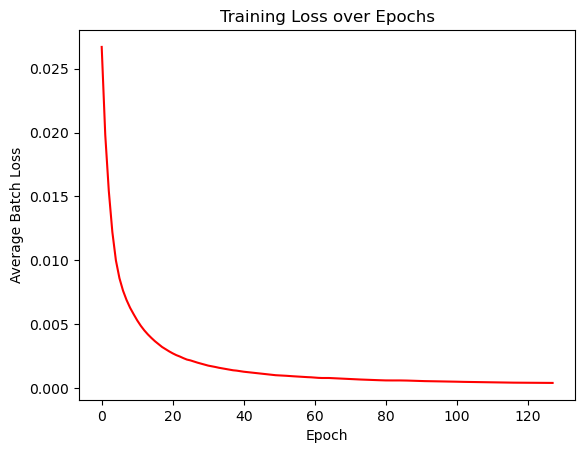

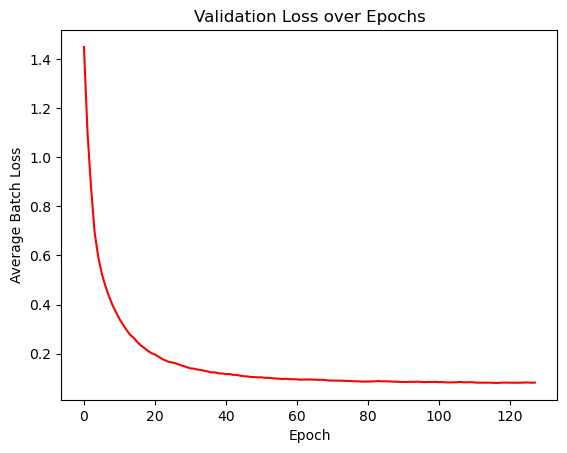

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.020575
Avg batch PSNR: 23.397155
Avg batch SSIM: 0.932408

TRAINING RECONSRTUCTION MODEL FOR: s1tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.450947
-------------------------------
Epoch 

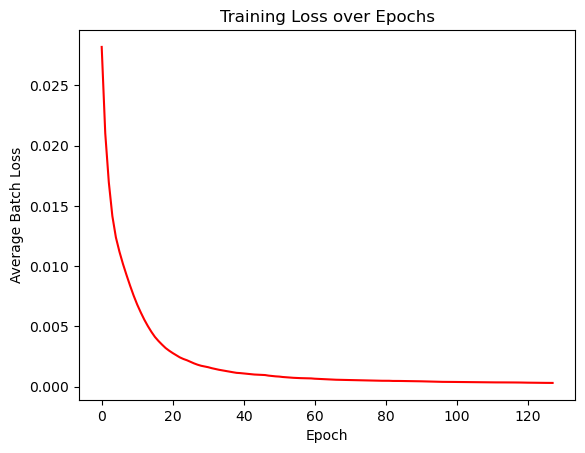

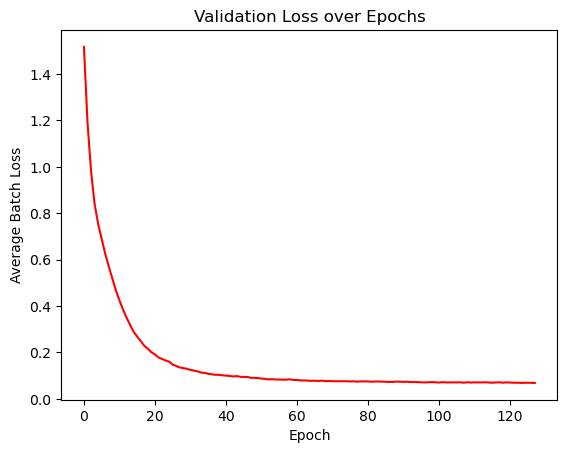

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.017195
Avg batch PSNR: 24.434853
Avg batch SSIM: 0.947057

TRAINING RECONSRTUCTION MODEL FOR: s200tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.437830
-------------------------------
Epoc

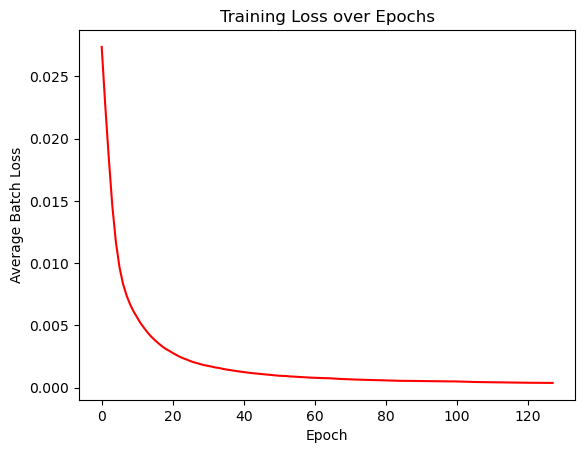

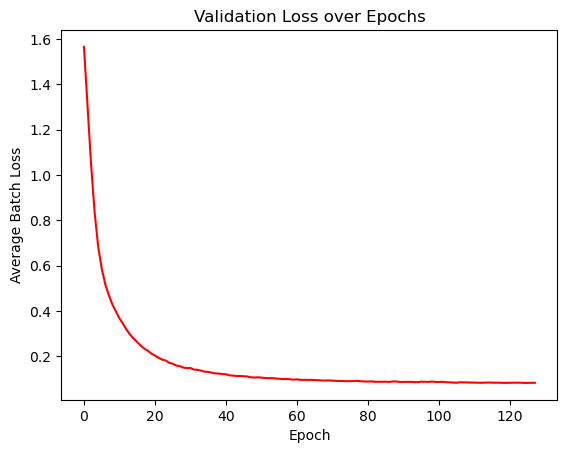

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.020753
Avg batch PSNR: 23.540831
Avg batch SSIM: 0.933710

TRAINING RECONSRTUCTION MODEL FOR: s20tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.512320
-------------------------------
Epoch

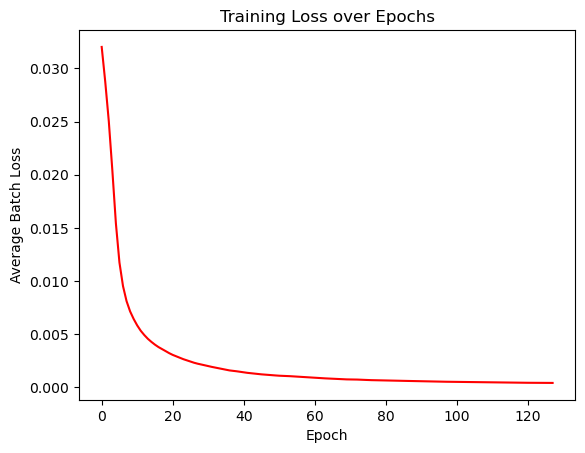

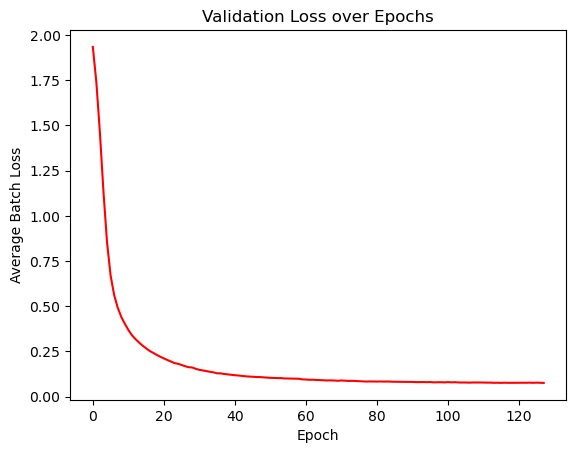

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018880
Avg batch PSNR: 23.815804
Avg batch SSIM: 0.941502

TRAINING RECONSRTUCTION MODEL FOR: s2tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.501694
-------------------------------
Epoch 

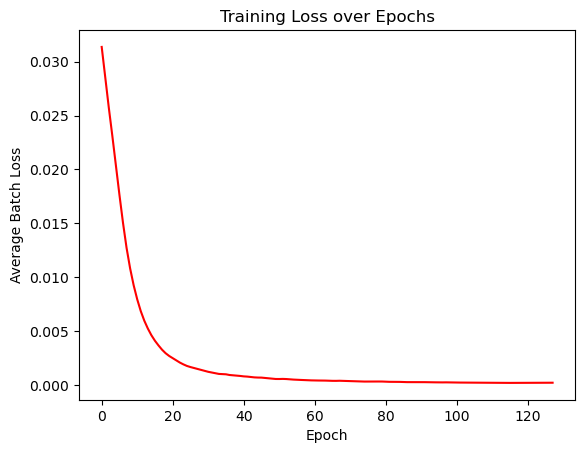

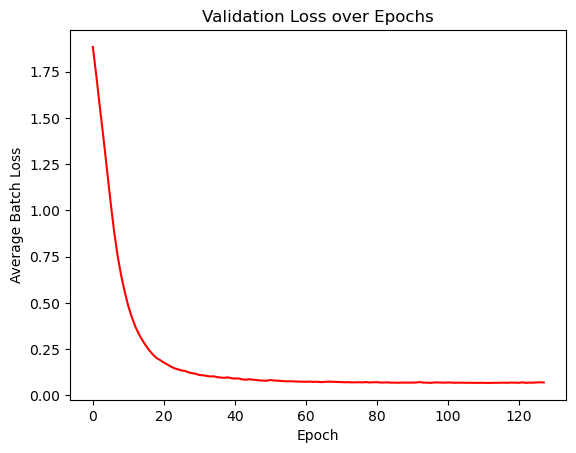

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.017433
Avg batch PSNR: 24.615317
Avg batch SSIM: 0.946211

TRAINING RECONSRTUCTION MODEL FOR: s500tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.488470
-------------------------------
Epoc

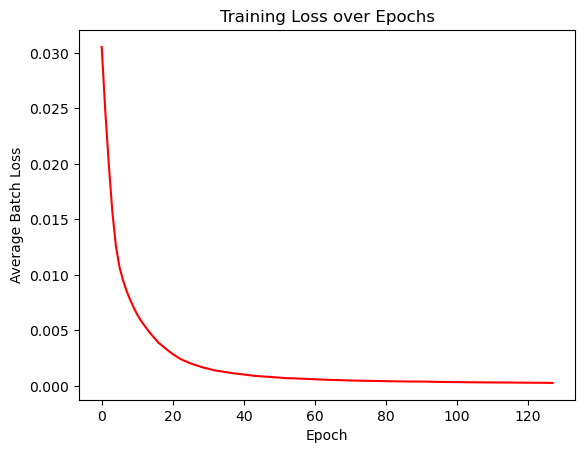

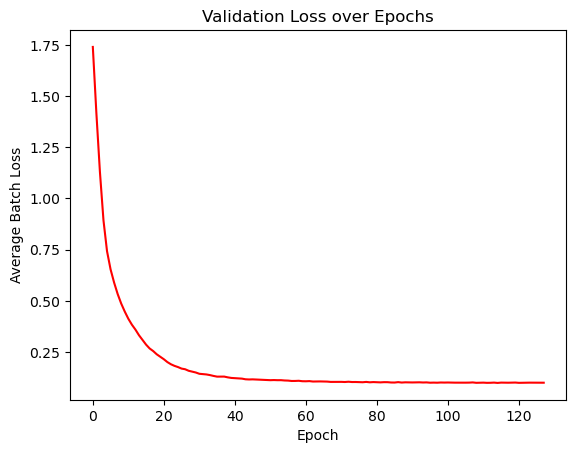

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.024999
Avg batch PSNR: 22.683511
Avg batch SSIM: 0.916922

TRAINING RECONSRTUCTION MODEL FOR: s50tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.478925
-------------------------------
Epoch

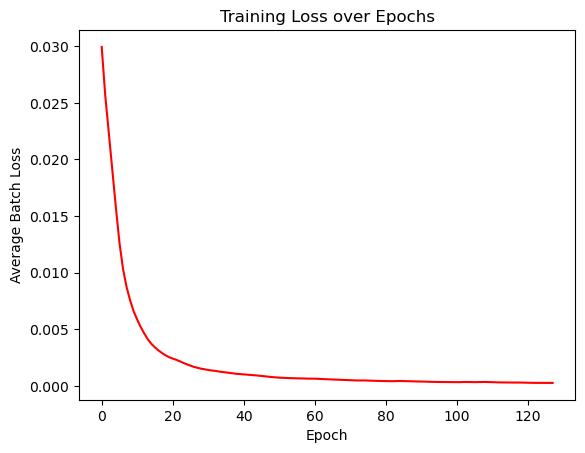

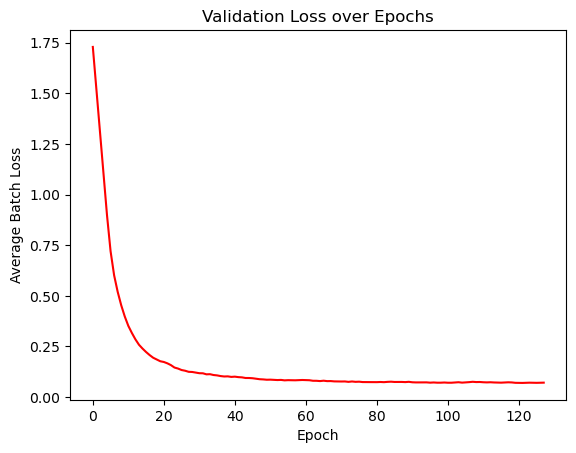

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.017830
Avg batch PSNR: 24.322163
Avg batch SSIM: 0.943535

TRAINING RECONSRTUCTION MODEL FOR: s5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.464075
-------------------------------
Epoch 

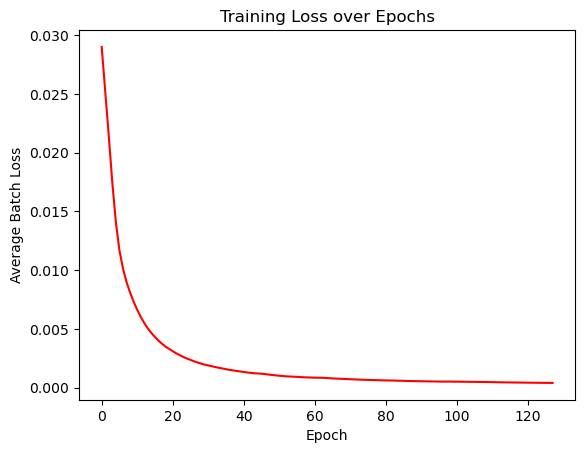

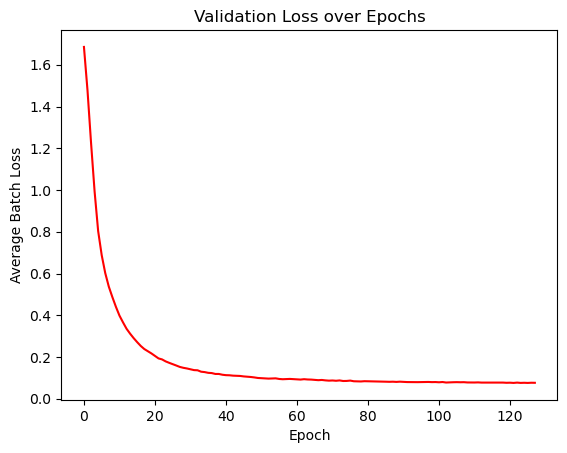

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.019129
Avg batch PSNR: 23.774516
Avg batch SSIM: 0.935907

TRAINING RECONSRTUCTION MODEL FOR: snnfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.495048
-------------------------------
Epoch 

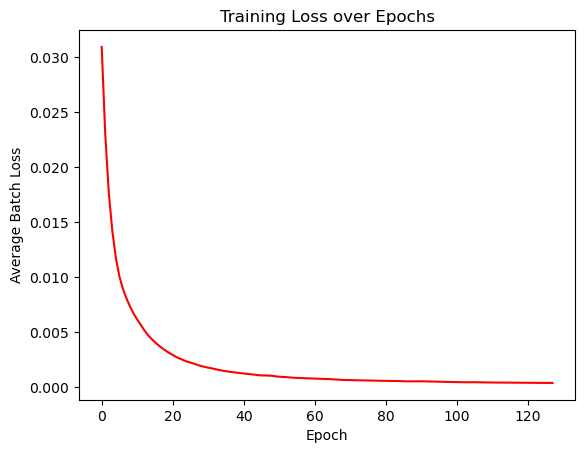

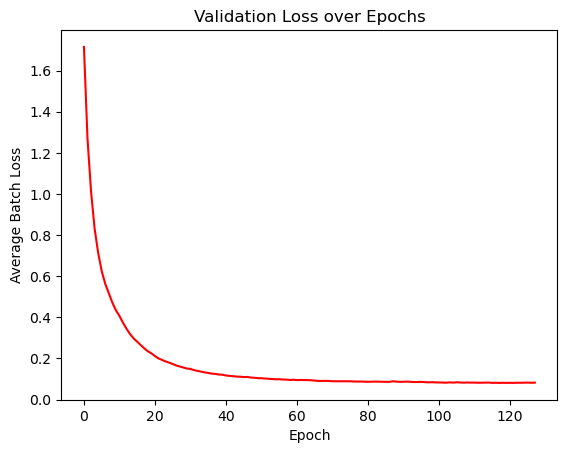

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.020663
Avg batch PSNR: 23.423411
Avg batch SSIM: 0.934601

TRAINING RECONSRTUCTION MODEL FOR: s100n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.490007
-------------------------------
Epoch 

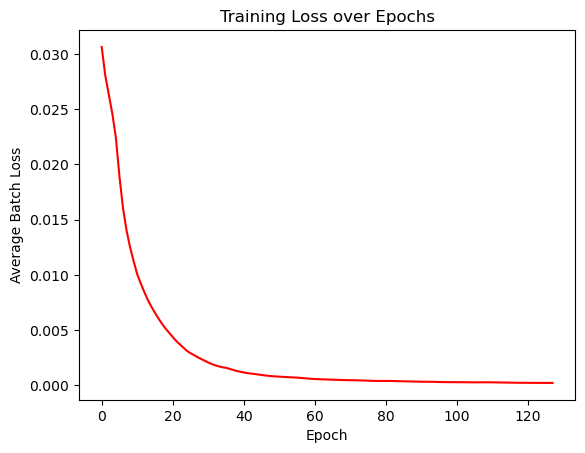

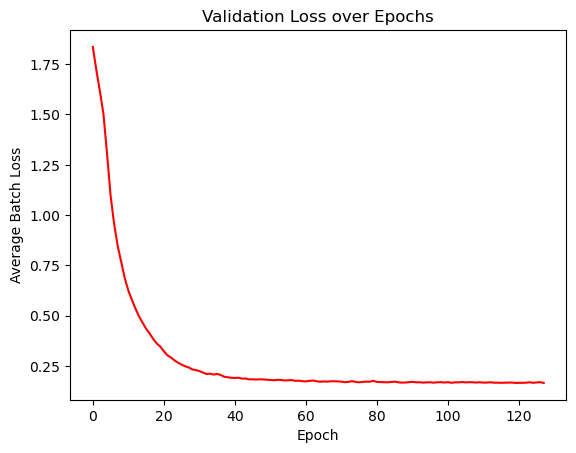

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.041559
Avg batch PSNR: 20.098393
Avg batch SSIM: 0.841619

TRAINING RECONSRTUCTION MODEL FOR: s62p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.448562
-------------------------------
Epoch

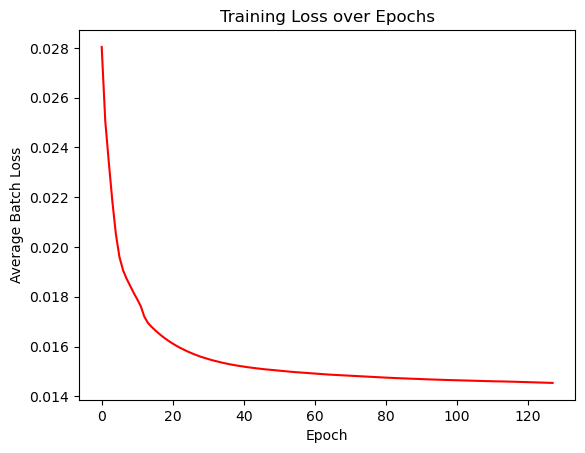

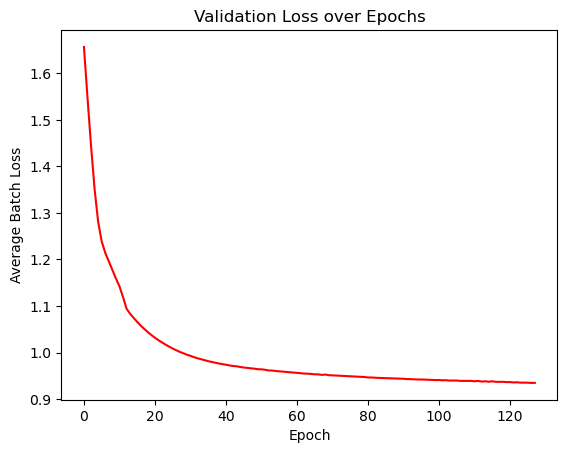

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.233755
Avg batch PSNR: 12.896381
Avg batch SSIM: 0.140748

TRAINING RECONSRTUCTION MODEL FOR: s75n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.544017
-------------------------------
Epoch 8

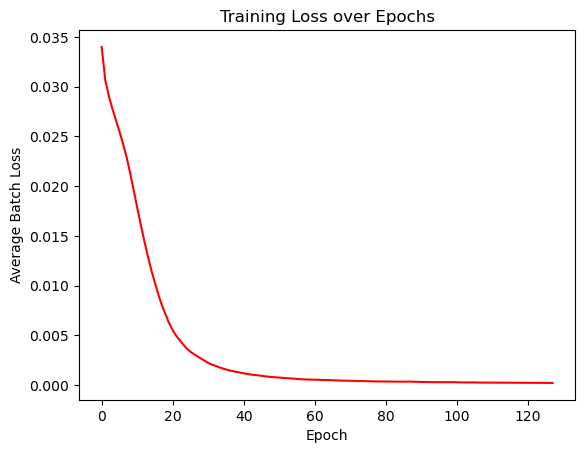

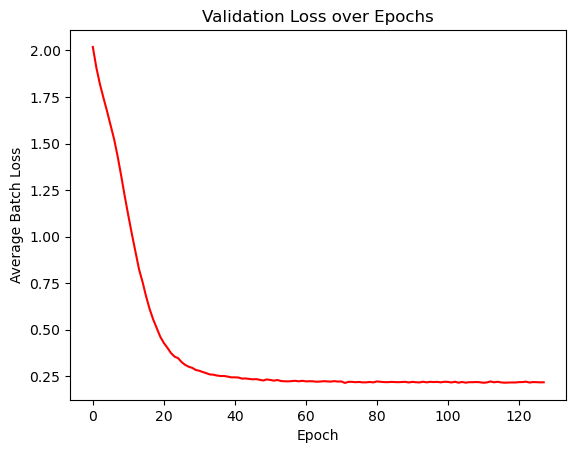

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.054363
Avg batch PSNR: 18.909934
Avg batch SSIM: 0.799821

TRAINING RECONSRTUCTION MODEL FOR: s87p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.518753
-------------------------------
Epoch

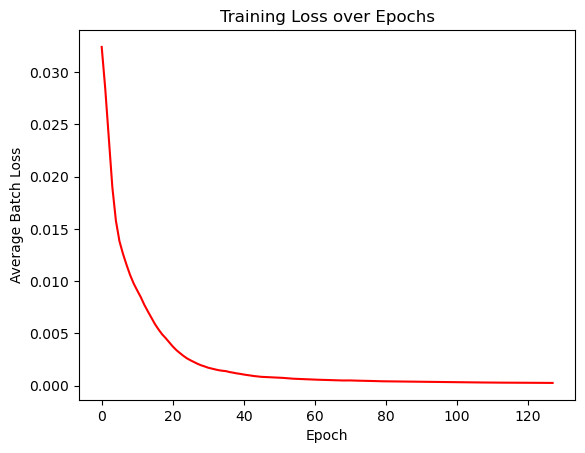

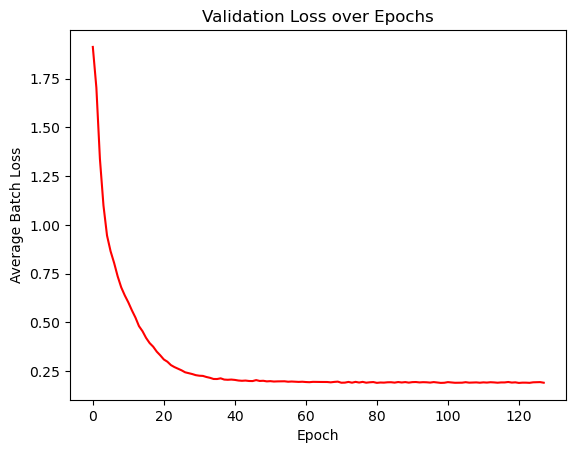

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.047417
Avg batch PSNR: 19.490301
Avg batch SSIM: 0.819675

TRAINING RECONSRTUCTION MODEL FOR: sa25n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.479166
-------------------------------
Epoch 

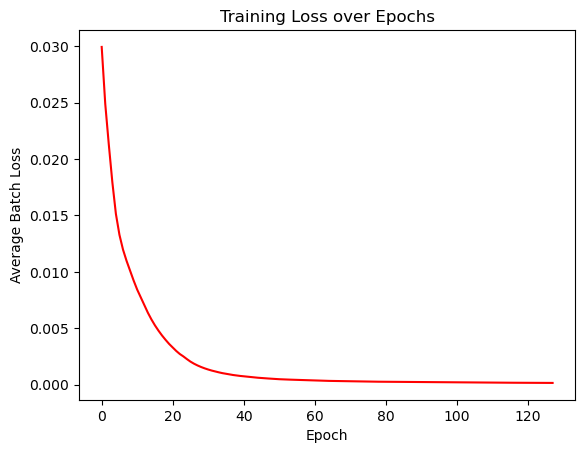

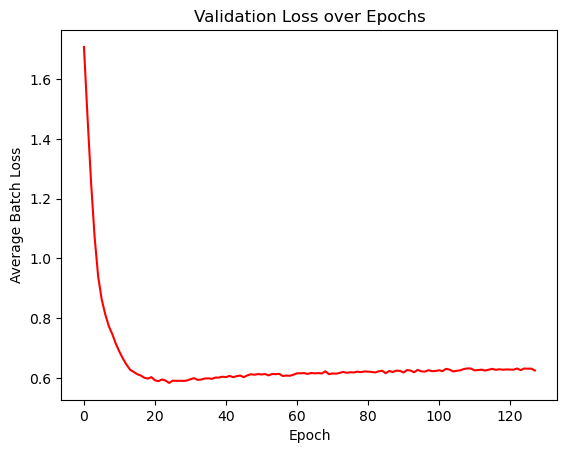

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.156241
Avg batch PSNR: 14.352902
Avg batch SSIM: 0.444028

TRAINING RECONSRTUCTION MODEL FOR: sa37n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.497531
-------------------------------
Epoch 

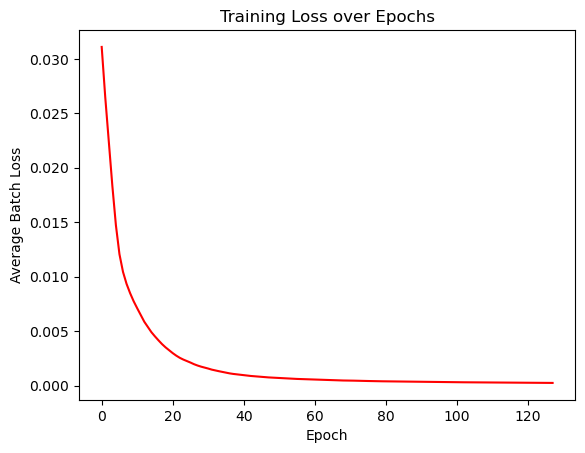

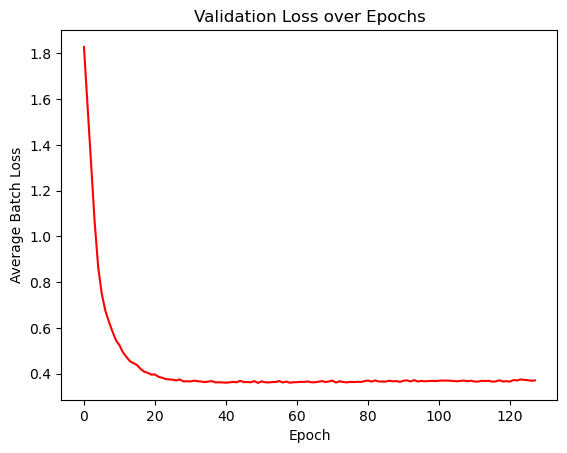

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.092513
Avg batch PSNR: 16.505113
Avg batch SSIM: 0.656088

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.439487
-------------------------------
Epoch 

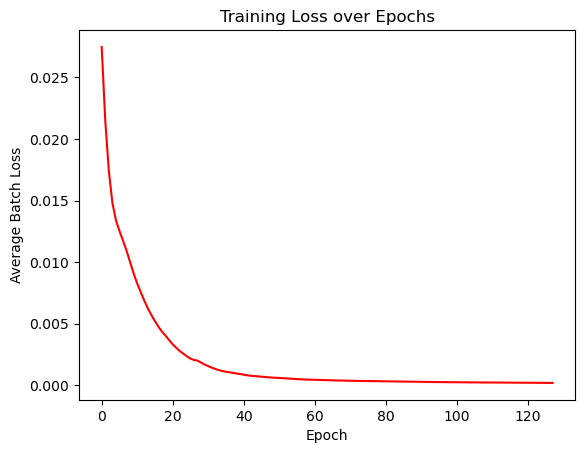

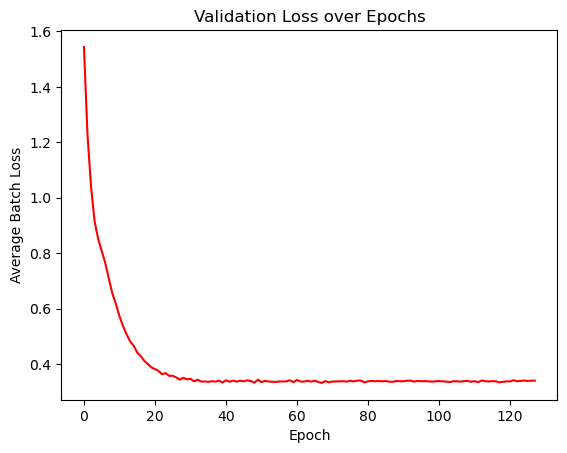

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.084895
Avg batch PSNR: 16.779426
Avg batch SSIM: 0.680988

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.429314
-------------------------------
Epoch 

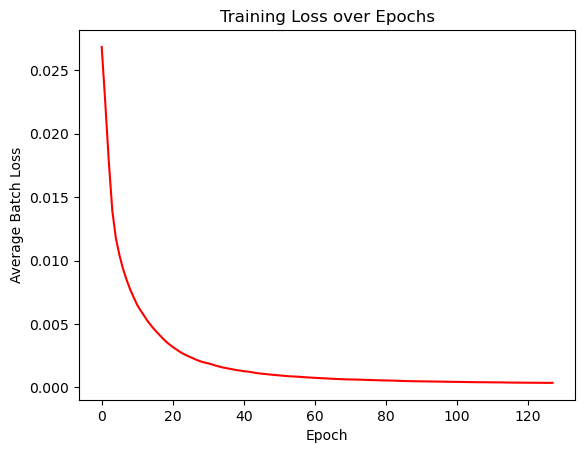

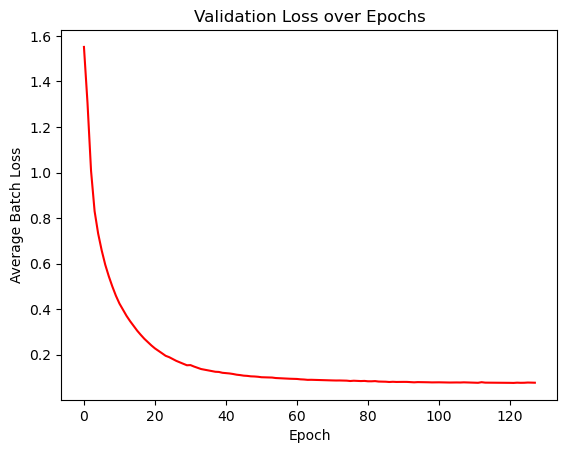

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.019264
Avg batch PSNR: 23.832098
Avg batch SSIM: 0.938916

TRAINING RECONSRTUCTION MODEL FOR: s25fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.483852
-------------------------------
Epoch 

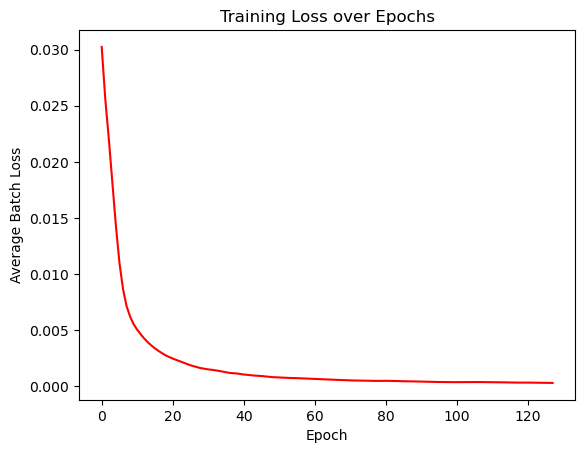

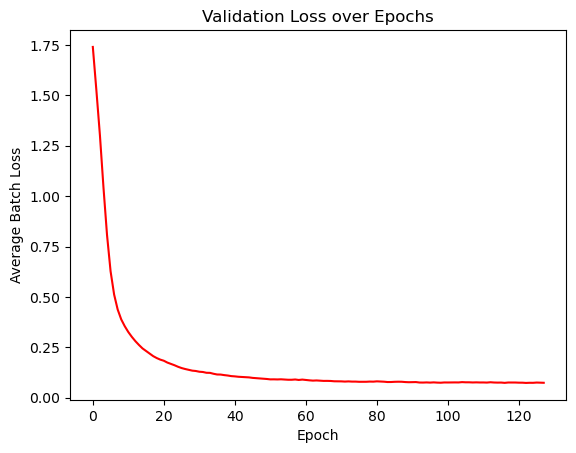

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018593
Avg batch PSNR: 23.823078
Avg batch SSIM: 0.942000

TRAINING RECONSRTUCTION MODEL FOR: s30fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.371888
-------------------------------
Epoch 

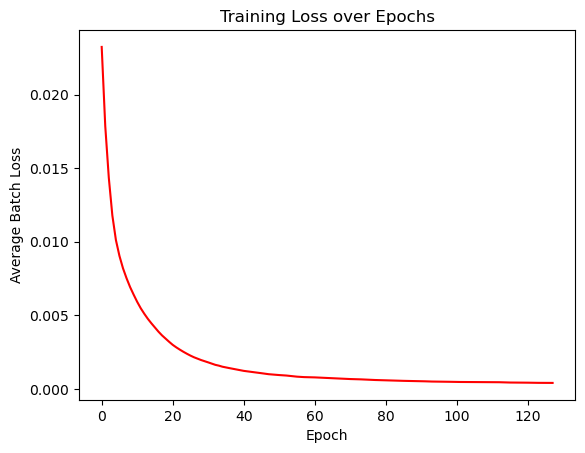

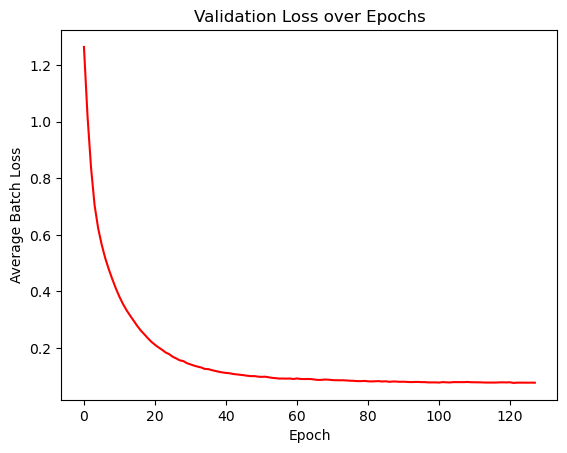

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.019361
Avg batch PSNR: 23.841894
Avg batch SSIM: 0.938157

TRAINING RECONSRTUCTION MODEL FOR: s35fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.494944
-------------------------------
Epoch 

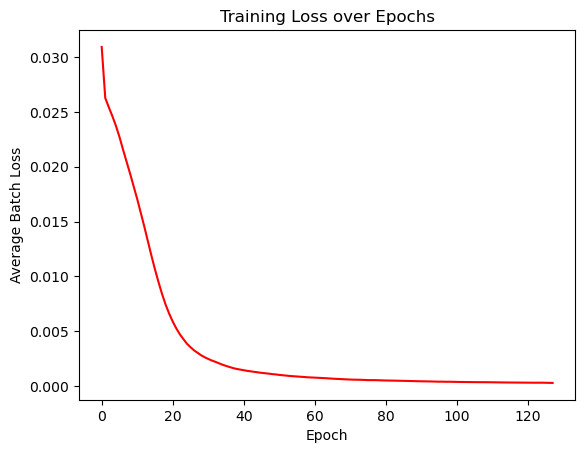

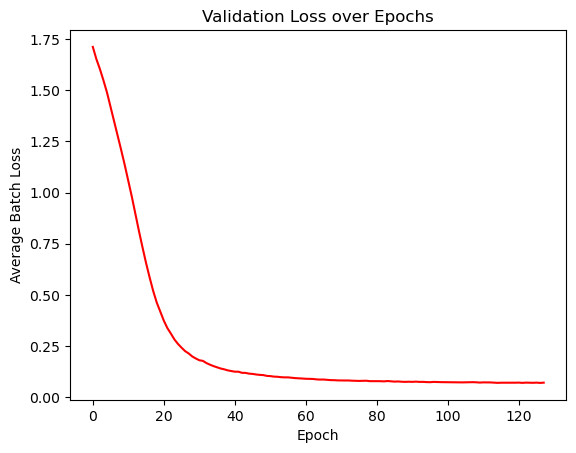

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.017805
Avg batch PSNR: 24.361002
Avg batch SSIM: 0.944963

TRAINING RECONSRTUCTION MODEL FOR: s3fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.445414
-------------------------------
Epoch 8

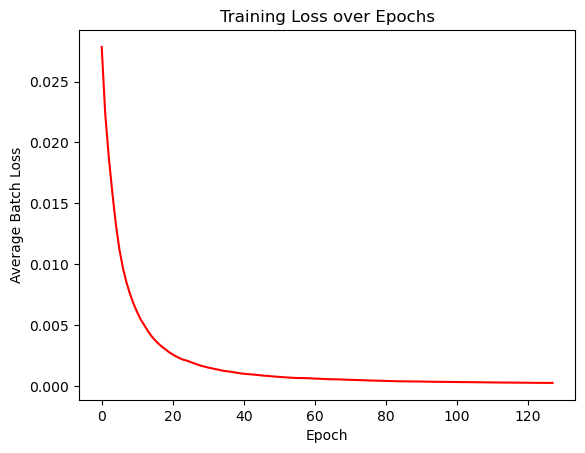

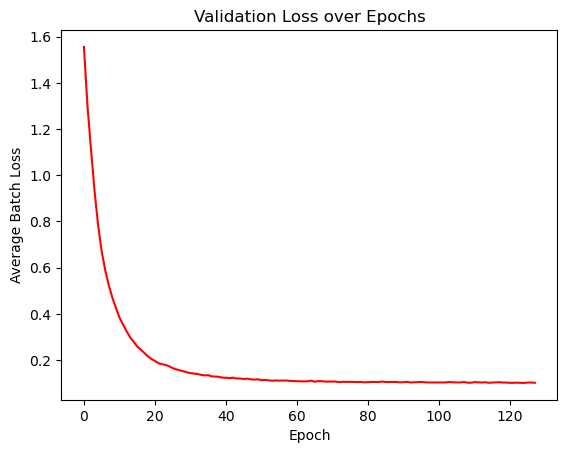

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025391
Avg batch PSNR: 22.570983
Avg batch SSIM: 0.910727

TRAINING RECONSRTUCTION MODEL FOR: s40fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.532062
-------------------------------
Epoch 

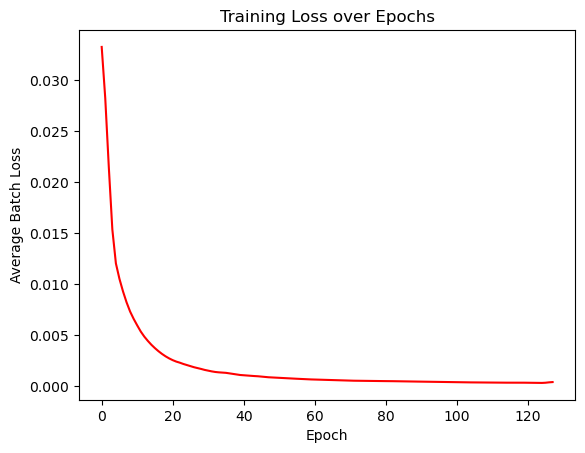

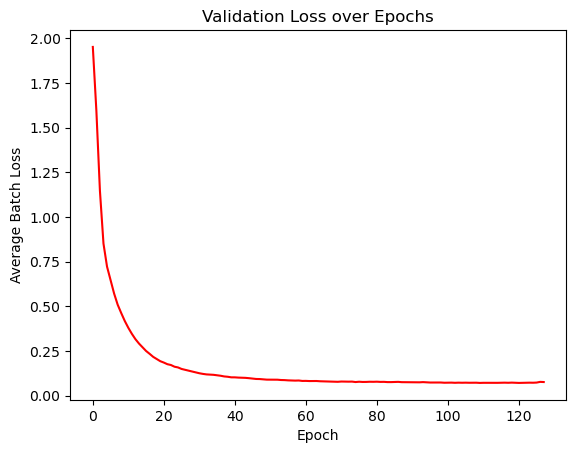

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018909
Avg batch PSNR: 23.865954
Avg batch SSIM: 0.939459

TRAINING RECONSRTUCTION MODEL FOR: s5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.506636
-------------------------------
Epoch 8

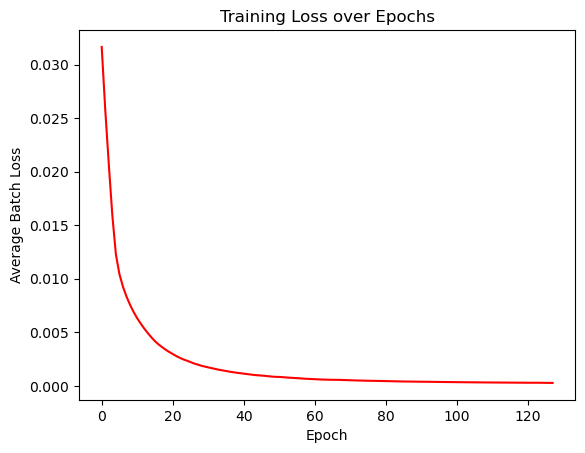

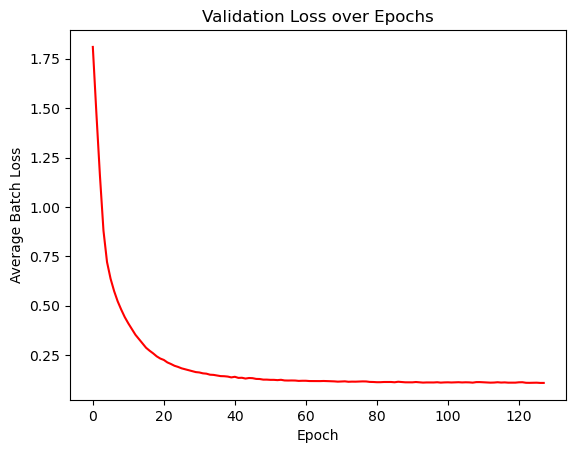

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.027348
Avg batch PSNR: 22.189957
Avg batch SSIM: 0.907120

TRAINING RECONSRTUCTION MODEL FOR: s6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.455529
-------------------------------
Epoch 8

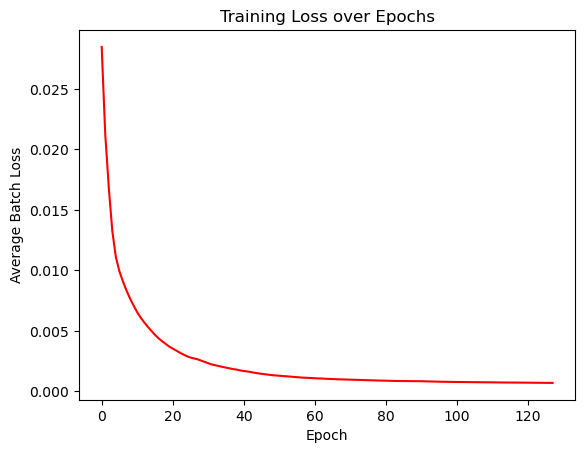

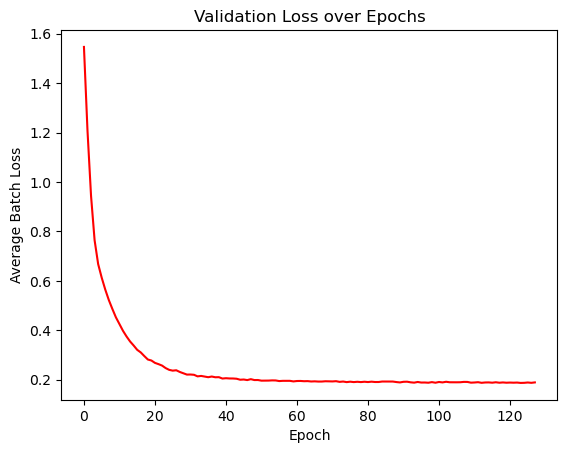

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.047221
Avg batch PSNR: 19.567230
Avg batch SSIM: 0.838556

TRAINING RECONSRTUCTION MODEL FOR: sa10fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.533930
-------------------------------
Epoch

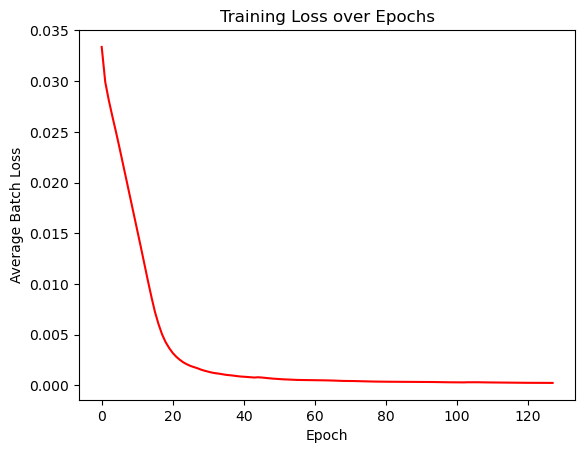

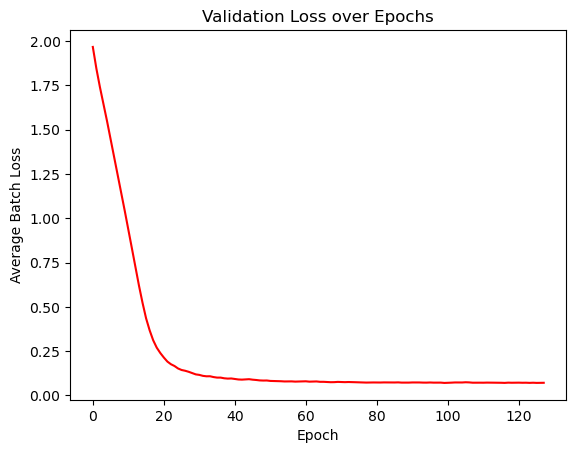

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.017896
Avg batch PSNR: 24.279364
Avg batch SSIM: 0.942660

TRAINING RECONSRTUCTION MODEL FOR: sa15fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.498752
-------------------------------
Epoch

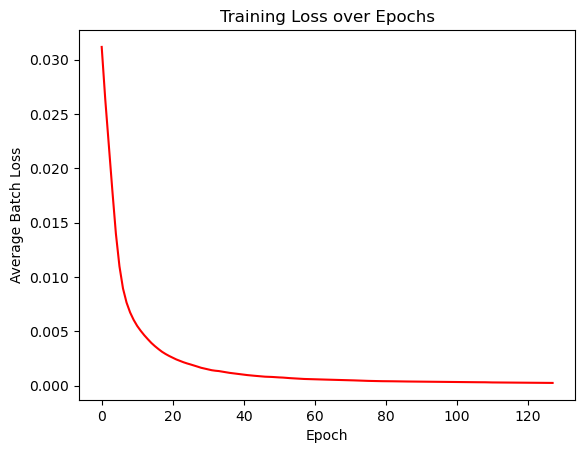

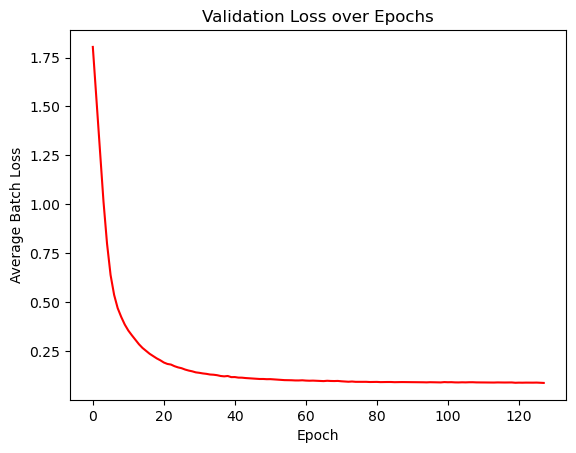

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.022049
Avg batch PSNR: 22.933537
Avg batch SSIM: 0.929213


In [12]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 300

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/withASE/direct'):
    val_loss, val_psnr, val_ssim = reconstruct("withASE", "direct", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/withASE/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("withASE", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/withASE/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/withoutASE/direct'):
    val_loss, val_psnr, val_ssim = reconstruct("withoutASE", "direct", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/withoutASE/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("withoutASE", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/withoutASE/reconstruction_results.csv'
results.to_csv(filename, index=False)


TRAINING RECONSRTUCTION MODEL FOR: s62p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.490241
-------------------------------
Epoch 8
Avg batch loss: 0.179597
-------------------------------
Epoch 16
Avg batc

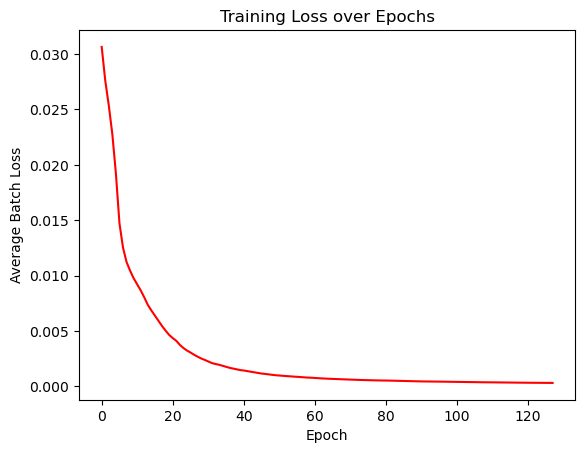

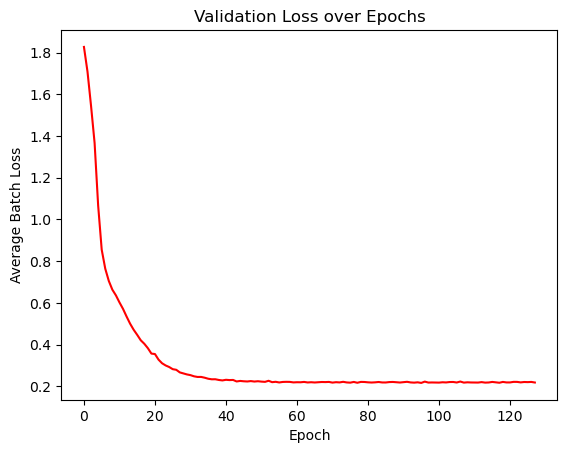

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.054434
Avg batch PSNR: 18.980093
Avg batch SSIM: 0.795057


In [12]:
# RECOMPILING LOCAL MINIMUM CASE
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 300

# VARIED INTEGRATION TIMES
filename = f'../data/features/withoutASE/reconstruction_results.csv'
results = pd.read_csv(filename)
val_loss, val_psnr, val_ssim = reconstruct("withoutASE", "direct", 's62p5n40by40and240m', batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
results.loc[results.filename=='s62p5n40by40and240m', 'val_loss'] = val_loss
results.loc[results.filename=='s62p5n40by40and240m', 'val_psnr'] = val_psnr
results.loc[results.filename=='s62p5n40by40and240m', 'val_ssim'] = val_ssim
results.to_csv(filename, index=False)


TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.452984
-------------------------------
Epoch 8
Avg batch loss: 0.180546
-------------------------------
Epoch 16
Avg batch

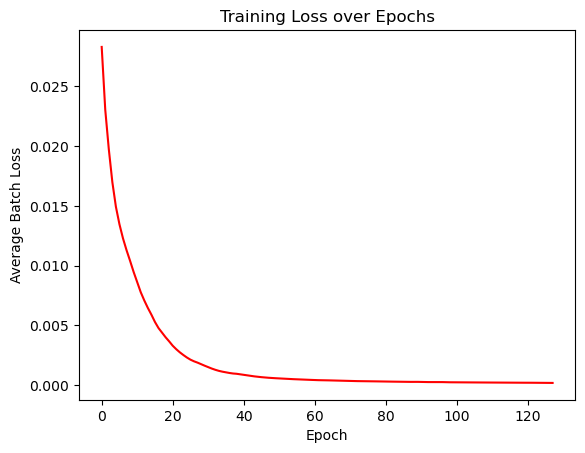

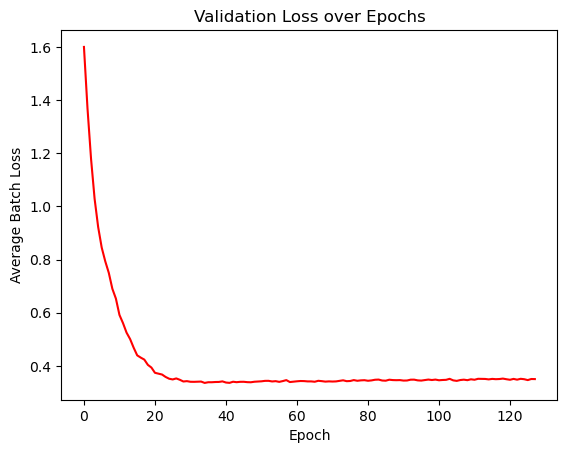

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.087582
Avg batch PSNR: 16.785557
Avg batch SSIM: 0.669047

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=200, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.539691
-------------------------------
Epoch 

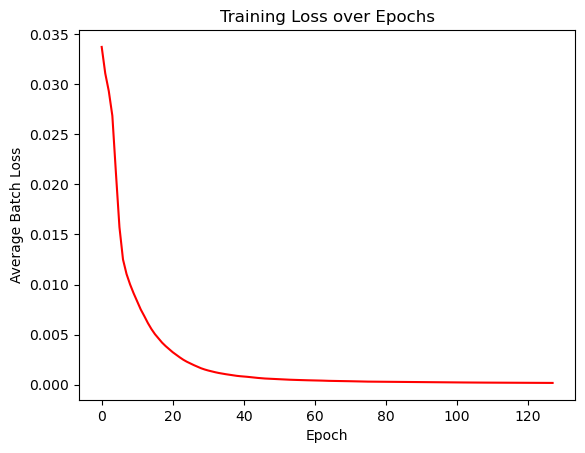

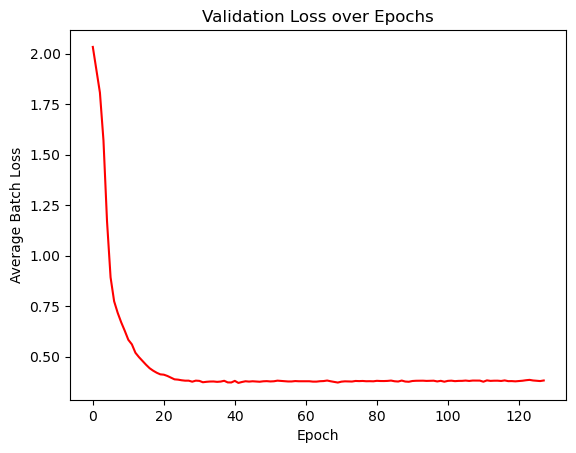

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.095621
Avg batch PSNR: 16.302139
Avg batch SSIM: 0.627849

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.485461
-------------------------------
Epoch 

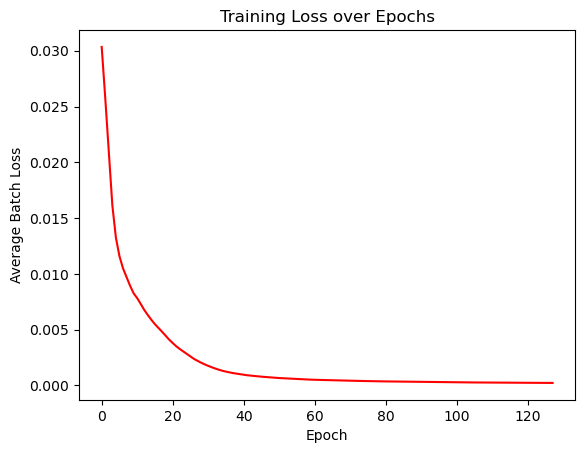

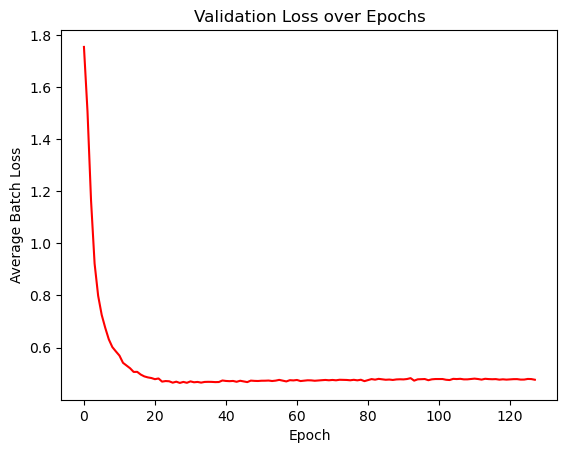

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.119164
Avg batch PSNR: 15.167826
Avg batch SSIM: 0.542857

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=75, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.523511
-------------------------------
Epoch 8

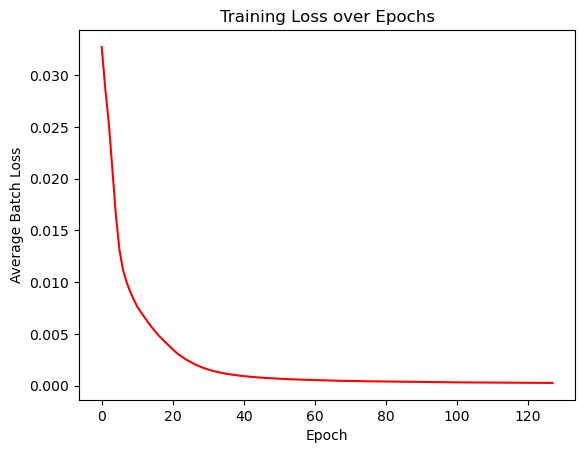

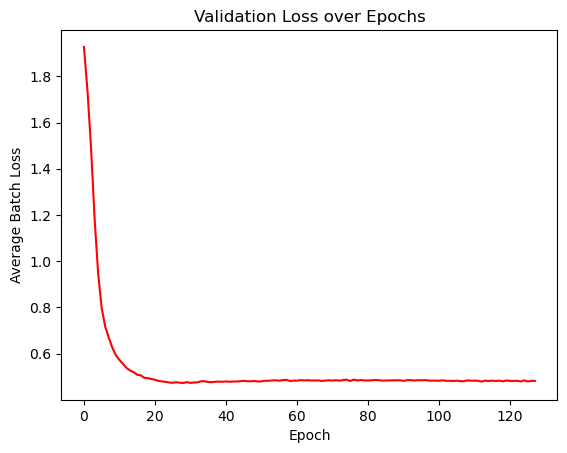

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.120561
Avg batch PSNR: 15.237396
Avg batch SSIM: 0.533064

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=50, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.490125
-------------------------------
Epoch 8

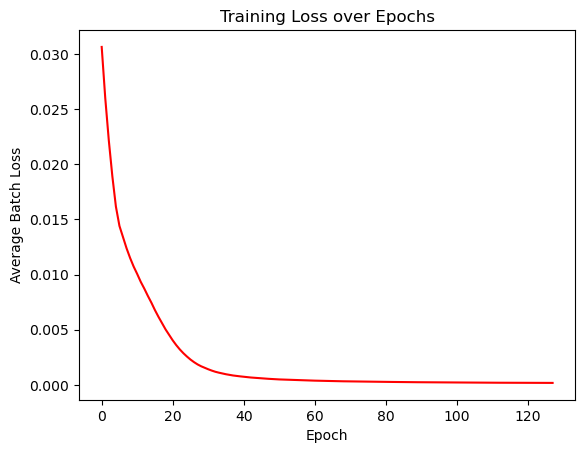

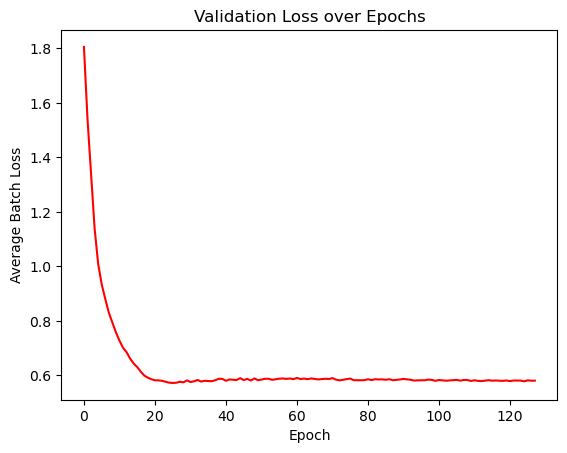

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.145164
Avg batch PSNR: 14.511234
Avg batch SSIM: 0.465305

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=25, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.467018
-------------------------------
Epoch 8

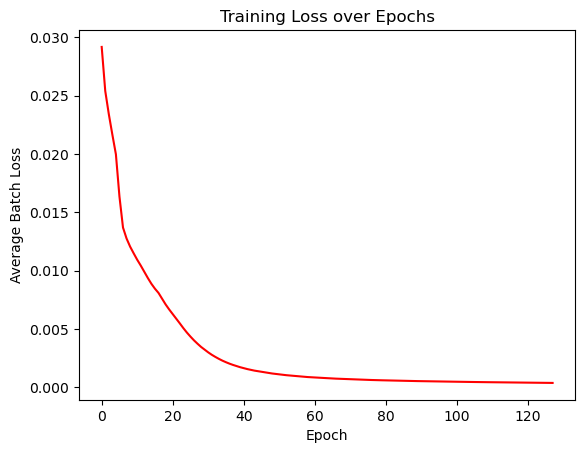

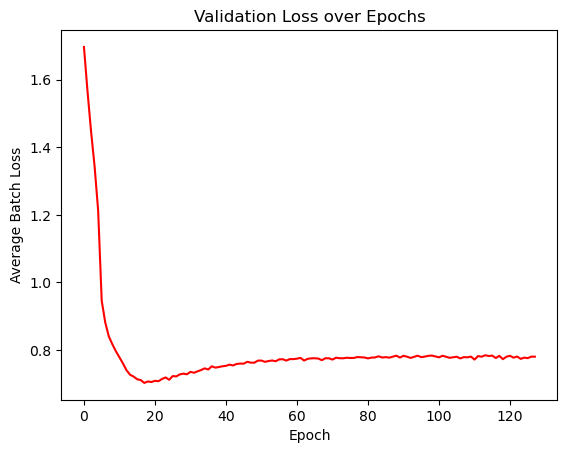

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.195064
Avg batch PSNR: 13.197876
Avg batch SSIM: 0.320399

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.483740
-------------------------------
Epoch 8

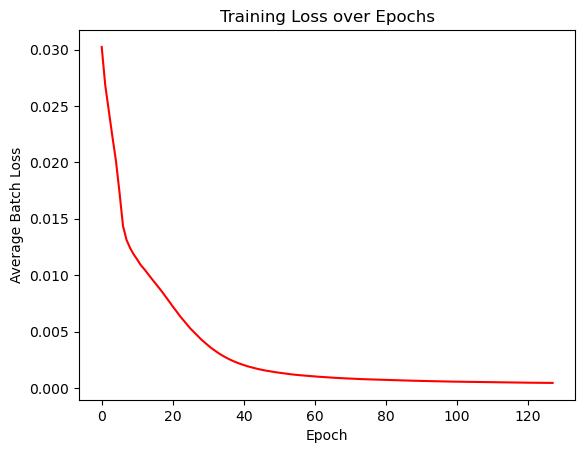

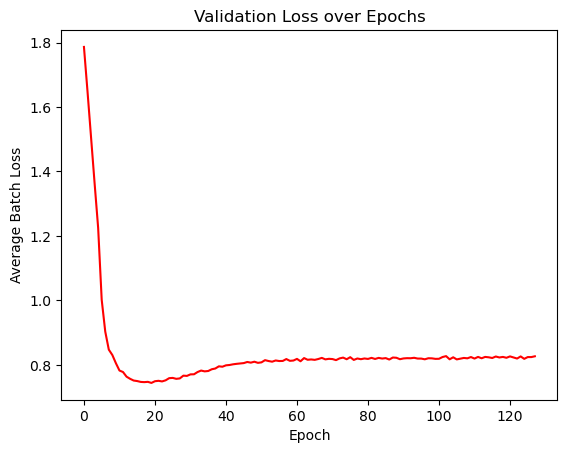

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.206616
Avg batch PSNR: 12.913471
Avg batch SSIM: 0.282760

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=15, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.517808
-------------------------------
Epoch 8

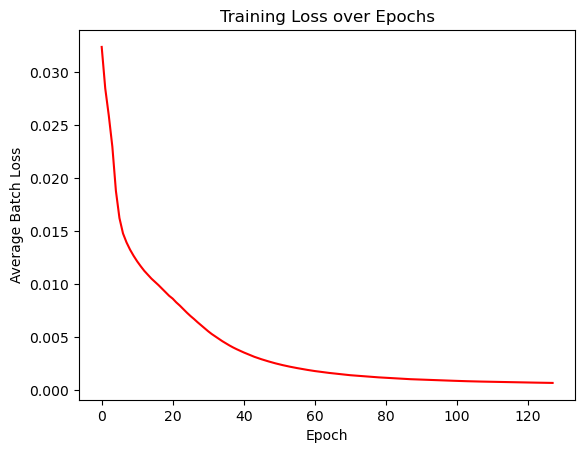

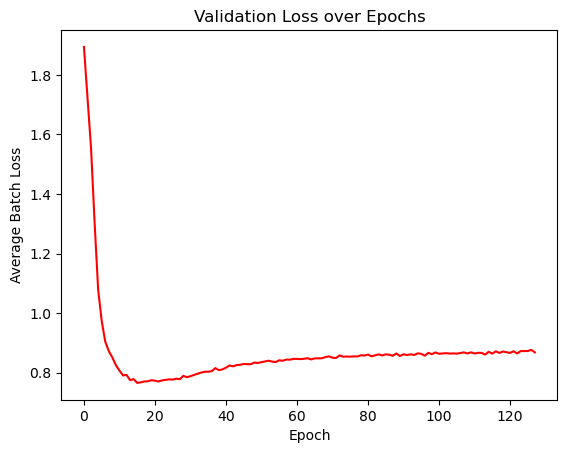

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.217044
Avg batch PSNR: 12.834312
Avg batch SSIM: 0.255559

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.486015
-------------------------------
Epoch 8

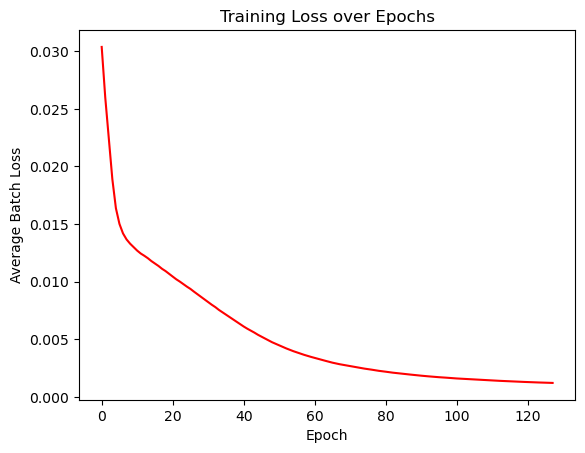

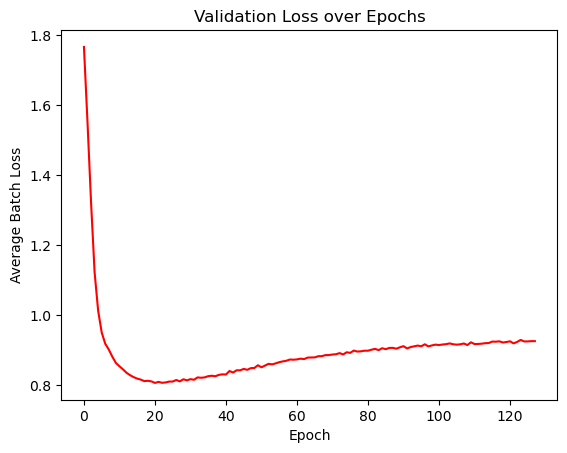

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.231581
Avg batch PSNR: 12.515638
Avg batch SSIM: 0.215660

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=5, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.479427
-------------------------------
Epoch 8


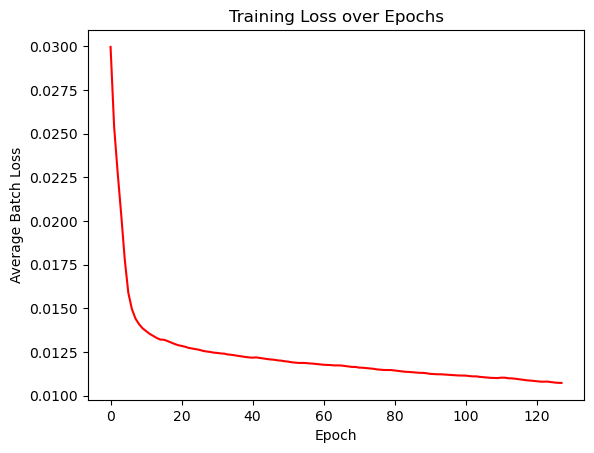

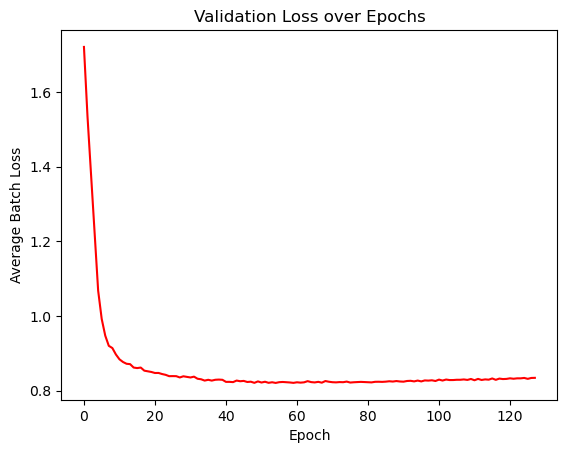

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.208589
Avg batch PSNR: 12.929249
Avg batch SSIM: 0.255793

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.468442
-------------------------------
Epoch 8


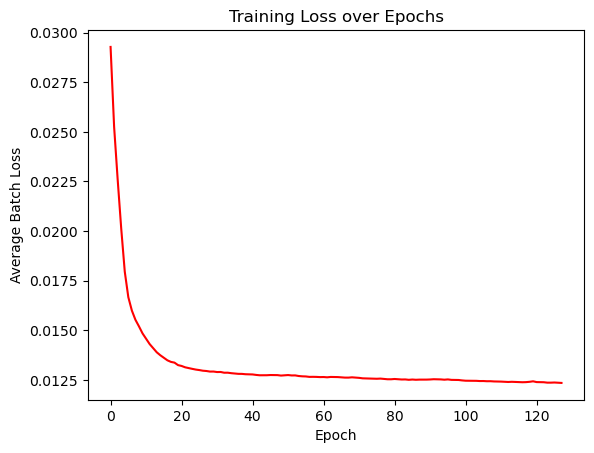

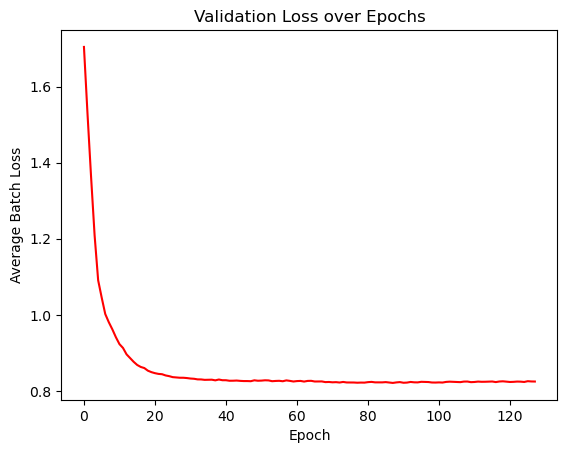

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.206141
Avg batch PSNR: 13.135191
Avg batch SSIM: 0.254692

TRAINING RECONSRTUCTION MODEL FOR: sa50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=3, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.472159
-------------------------------
Epoch 8


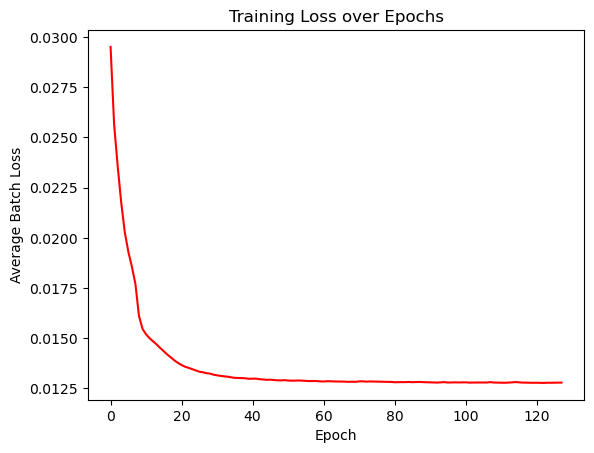

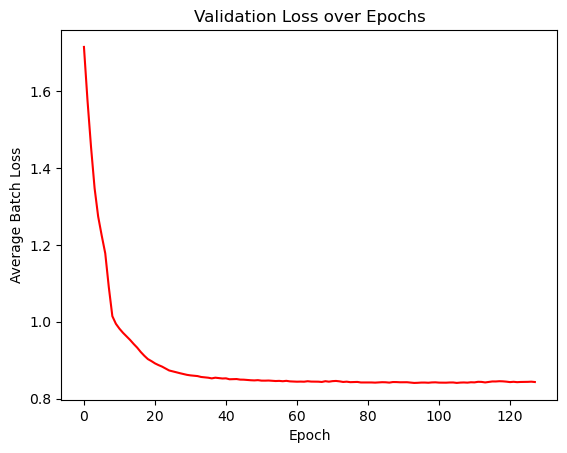

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.210759
Avg batch PSNR: 12.960828
Avg batch SSIM: 0.229358

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.527642
-------------------------------
Epoch 

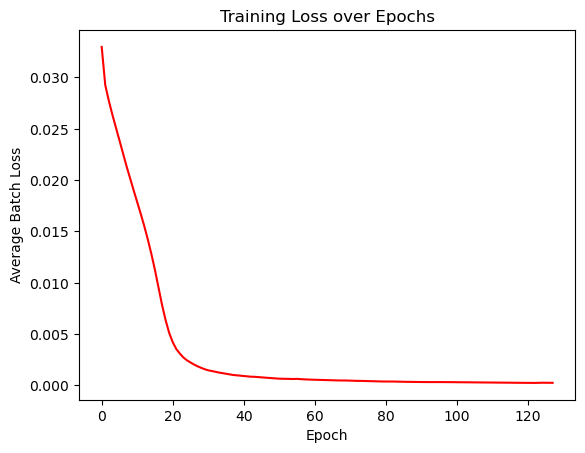

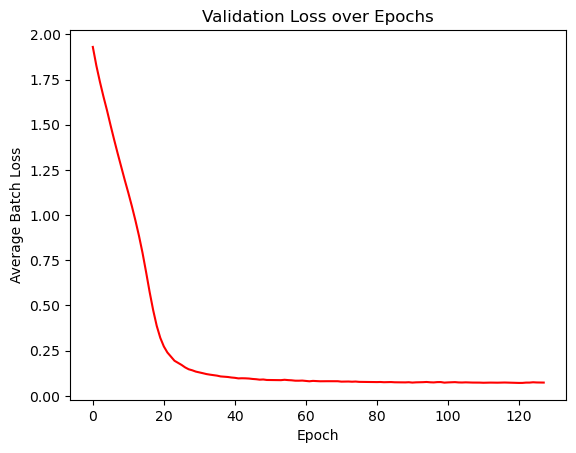

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018306
Avg batch PSNR: 24.036665
Avg batch SSIM: 0.939634

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=200, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.474337
-------------------------------
Epoch 

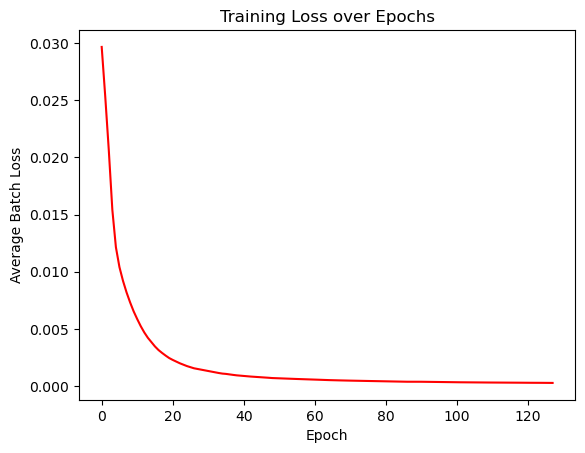

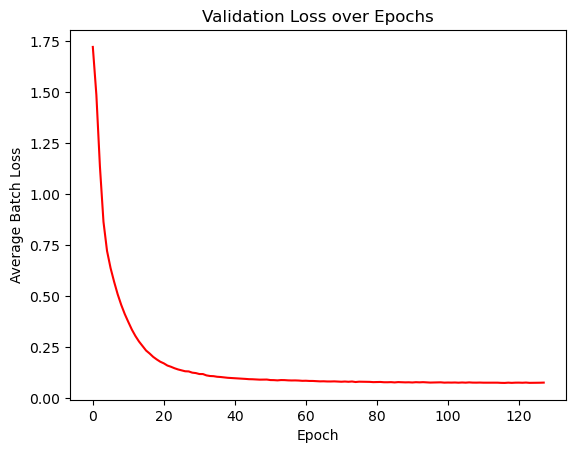

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018710
Avg batch PSNR: 24.127775
Avg batch SSIM: 0.943157

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.484846
-------------------------------
Epoch 

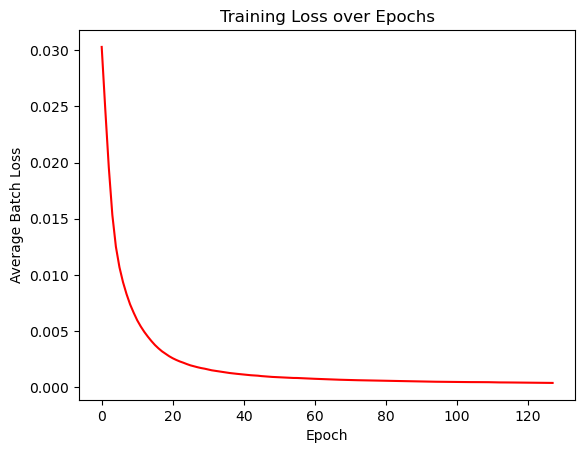

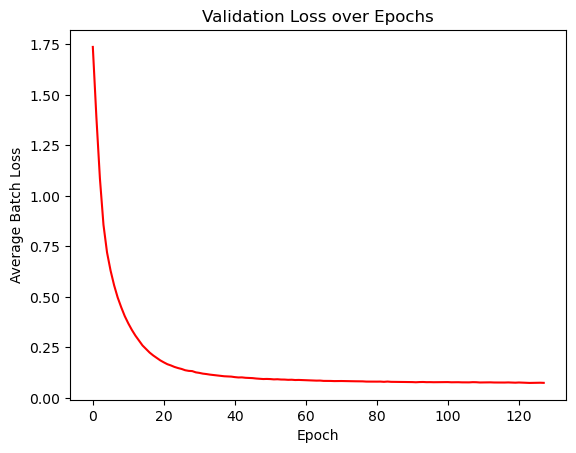

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018591
Avg batch PSNR: 24.048823
Avg batch SSIM: 0.942297

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=75, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.515022
-------------------------------
Epoch 8

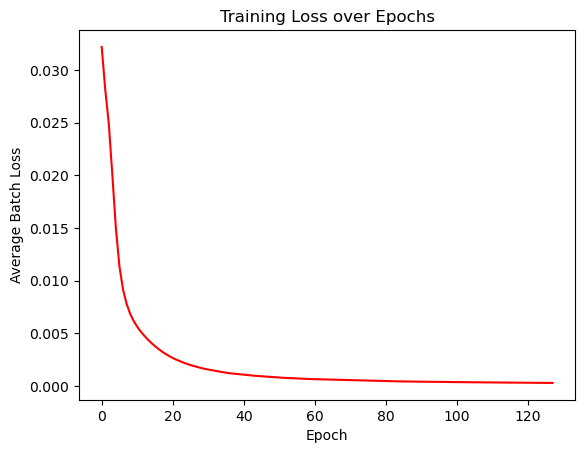

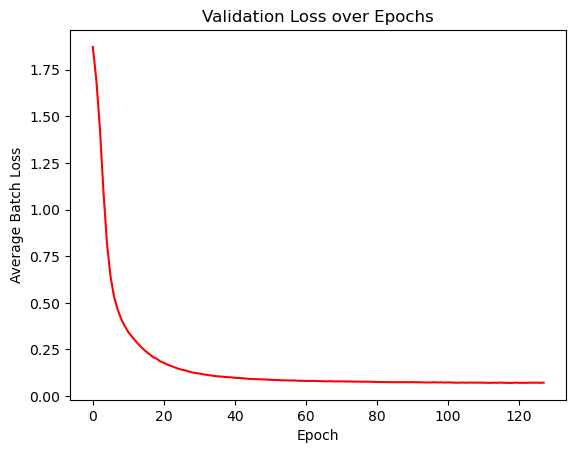

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.017987
Avg batch PSNR: 24.425513
Avg batch SSIM: 0.939905

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=50, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.475134
-------------------------------
Epoch 8

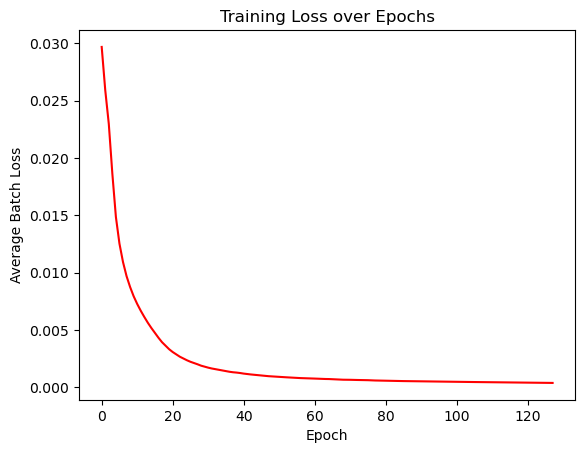

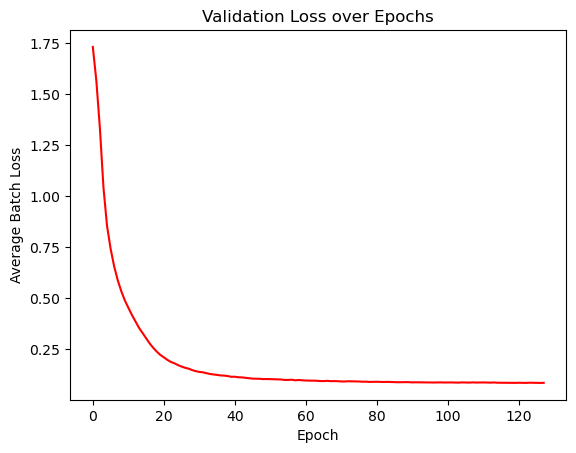

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.020761
Avg batch PSNR: 23.524663
Avg batch SSIM: 0.932572

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=25, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.471072
-------------------------------
Epoch 8

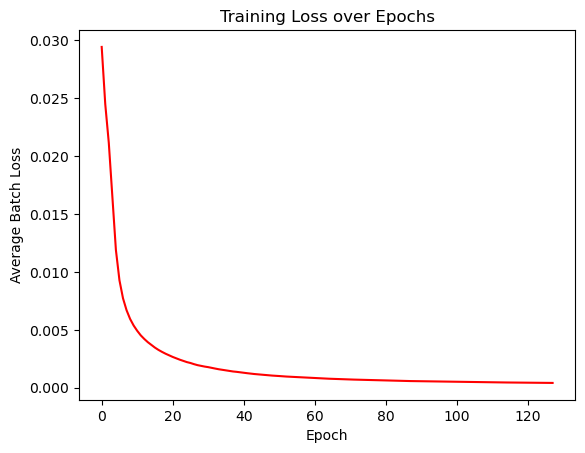

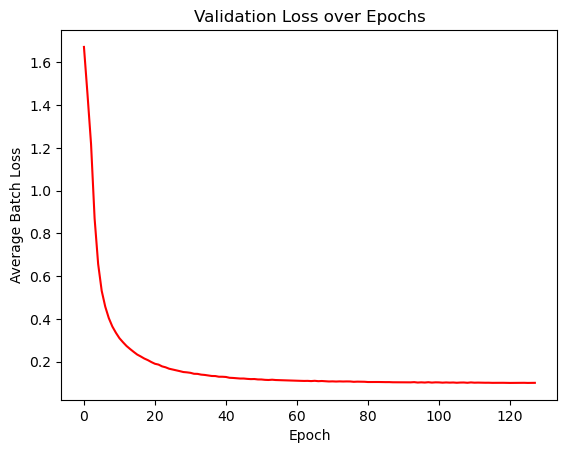

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025388
Avg batch PSNR: 22.504445
Avg batch SSIM: 0.914702

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.474911
-------------------------------
Epoch 8

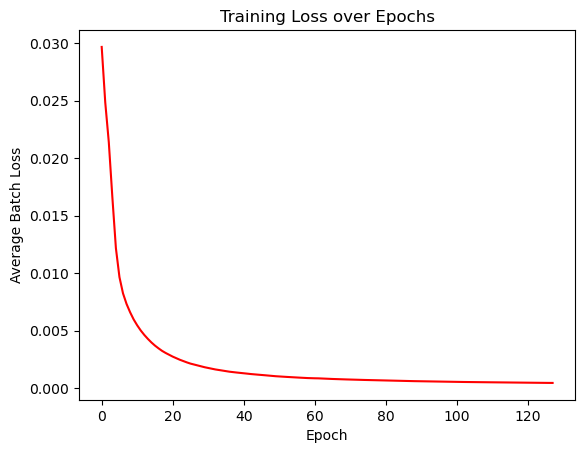

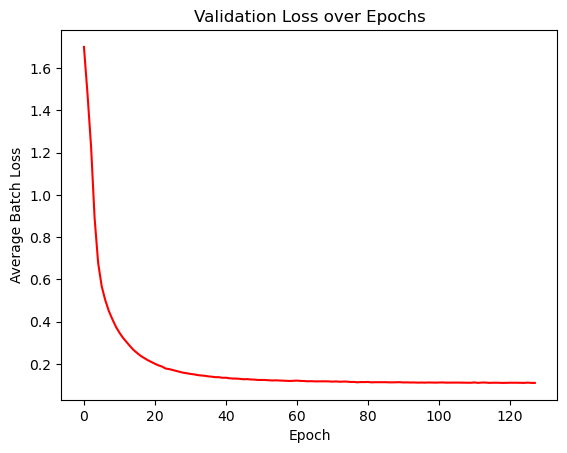

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.027573
Avg batch PSNR: 22.029164
Avg batch SSIM: 0.905197

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=15, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.465731
-------------------------------
Epoch 8

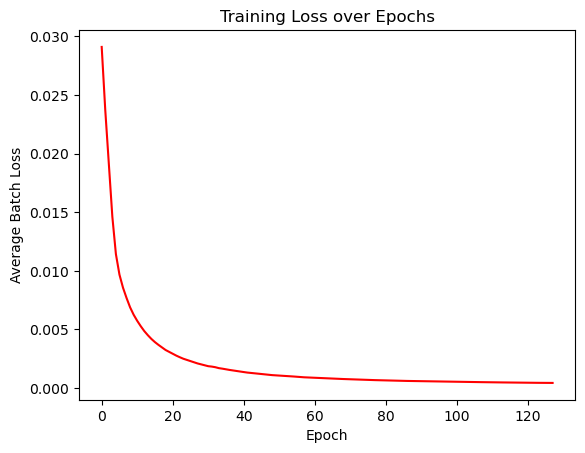

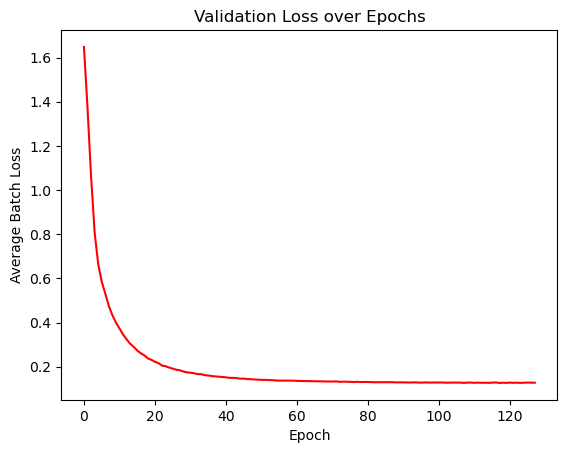

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.031970
Avg batch PSNR: 21.257762
Avg batch SSIM: 0.883047

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.472990
-------------------------------
Epoch 8

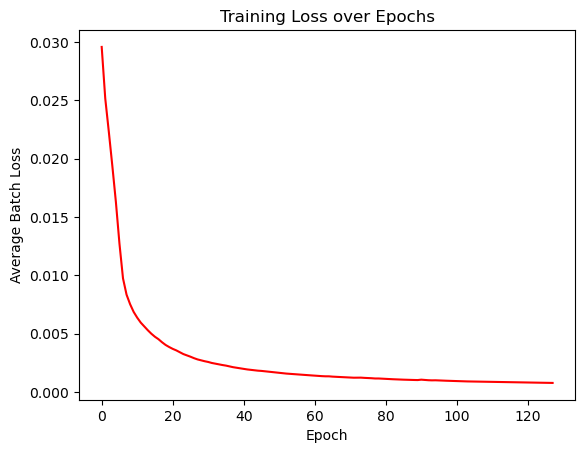

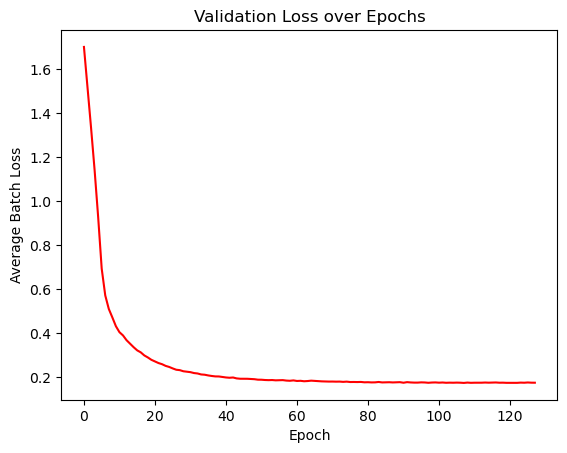

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.043921
Avg batch PSNR: 19.647219
Avg batch SSIM: 0.834884

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=5, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.447153
-------------------------------
Epoch 8


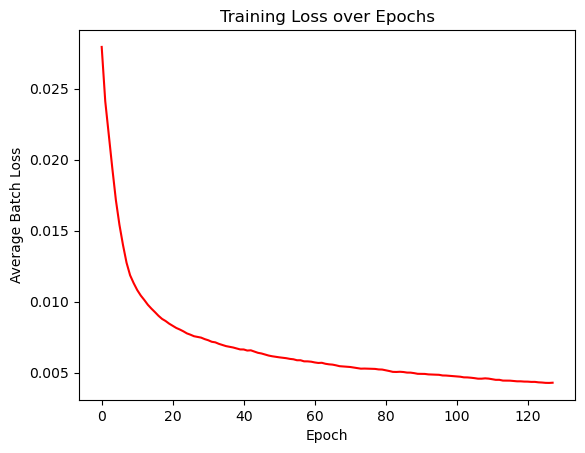

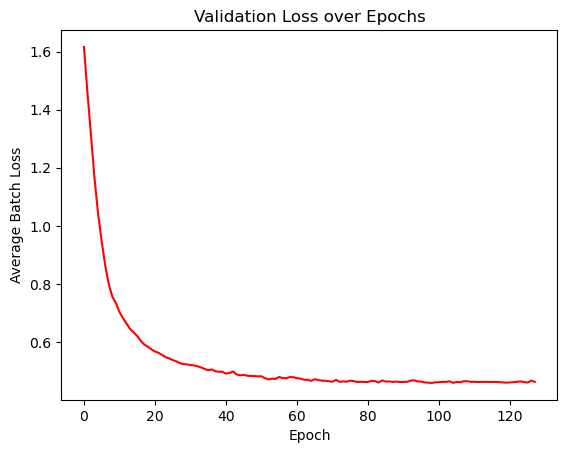

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.115664
Avg batch PSNR: 15.007663
Avg batch SSIM: 0.557780

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.477825
-------------------------------
Epoch 8


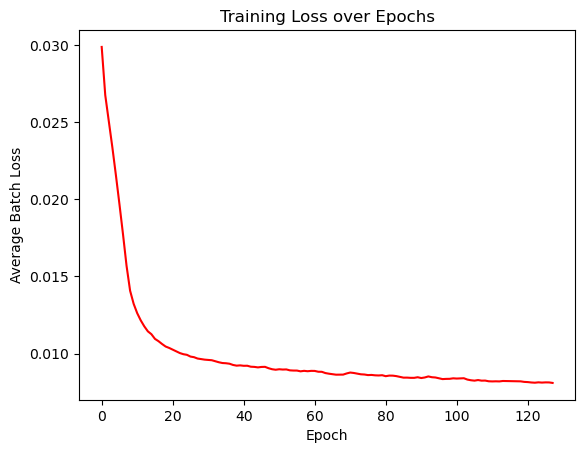

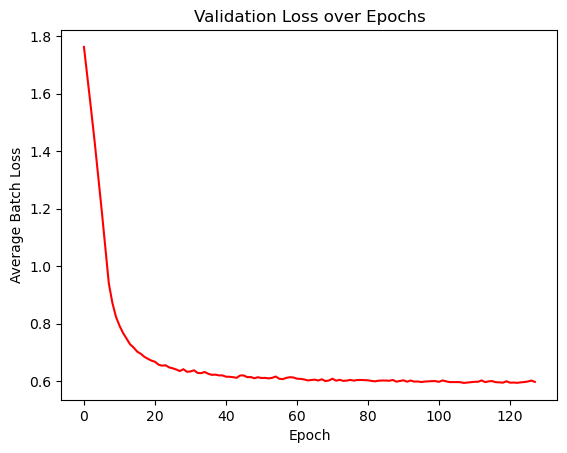

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.149318
Avg batch PSNR: 14.149193
Avg batch SSIM: 0.423905

TRAINING RECONSRTUCTION MODEL FOR: s20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=3, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.527166
-------------------------------
Epoch 8


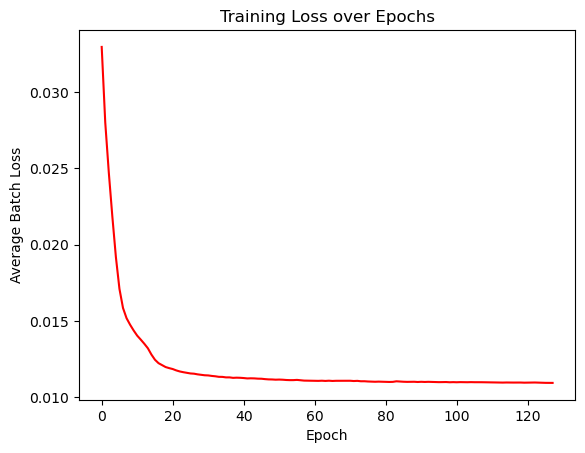

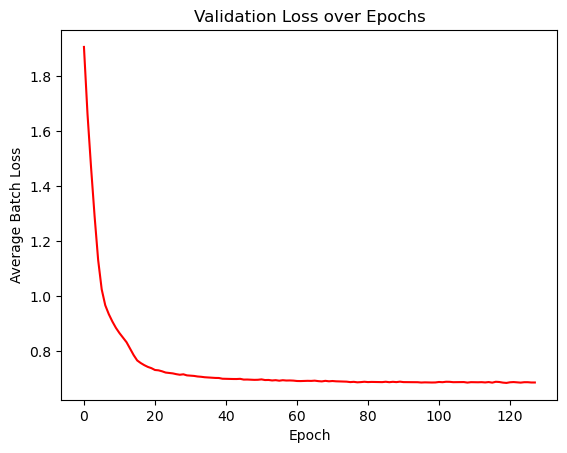

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.171680
Avg batch PSNR: 13.798316
Avg batch SSIM: 0.338415


In [4]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

features = [300,200,100,75,50,25,20,15,10,5,4,3]

# VARIED FEATURE COUNTS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
results['num_features'] = []

filename = 'sa50n40by40and240m'

for num_features in features:
    val_loss, val_psnr, val_ssim = reconstruct("withoutASE", "direct", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
    results['num_features'].append(num_features)
    
filename = 's20fv40by40and240m'

for num_features in features:
    val_loss, val_psnr, val_ssim = reconstruct("withoutASE", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
    results['num_features'].append(num_features)

results = pd.DataFrame.from_dict(results)
filename = f'../data/features/varied_features_results.csv'
results.to_csv(filename, index=False)
